In [132]:
import re
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold

In [133]:
######

import sys
USES_GOOGLE_COLAB = 'google.colab' in sys.modules

######

In [134]:
if USES_GOOGLE_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  DATA_ROOT = '/content/drive/MyDrive/Projet MIDL'
else:
  DATA_ROOT = './data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# I. Analyse exploratoire

## Répartition de critères tels que le nombre de participants par pays, la parité

Etudions l'évolution du nombre de participants par pays entre 2020 et 2024.

In [135]:
athletes_tokyo_df = pd.read_csv(f'{DATA_ROOT}/DataTokyo/athletes.csv')
athletes_paris_df = pd.read_csv(f'{DATA_ROOT}/DataParis/athletes.csv')

In [136]:
values_tokyo = athletes_tokyo_df[['country_code','name']].groupby('country_code').count()
values_paris = athletes_paris_df[['country_code','name']].groupby('country_code').count()

values = pd.merge(values_tokyo,values_paris,how='inner',on='country_code',suffixes=['_tokyo','_paris'])
values.sort_values(by='name_tokyo',ascending=False,inplace=True)
values = values.iloc[:20]

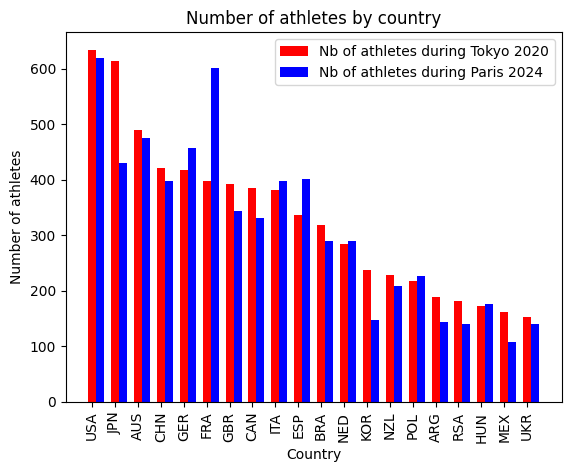

In [137]:
index = np.arange(len(values.index))
bar_width = 0.35

plt.bar(index,values['name_tokyo'],bar_width,label='Nb of athletes during Tokyo 2020',color='r')
plt.bar(index + bar_width,values['name_paris'],bar_width,label='Nb of athletes during Paris 2024',color='b')
plt.xticks(index,values.index,rotation='vertical')
plt.legend()
plt.title('Number of athletes by country')
plt.xlabel('Country')
plt.ylabel('Number of athletes')
plt.show()

On observe une différence du nombre d'athlètes très importante pour le Japon et la France, dûe au fonctionnement des qualifications pour les pays hôtes. On observe également un écart marqué par exemple pour la Corée du Sud (KOR) qui a plus participé aux JO de Tokyo ou l'Espagne (ESP) qui a plus participé à ceux de Paris. On pourrait donc supposer qu'il y a un facteur de proximité au pays hôte qui influence le nombre de participants par pays.

Etudions maintenant la parité au sein des athlètes.

In [138]:
nb_tokyo = [athletes_tokyo_df[athletes_tokyo_df['gender'] == 'Male'].shape[0],athletes_tokyo_df[athletes_tokyo_df['gender'] == 'Female'].shape[0]]
nb_paris = [athletes_paris_df[athletes_paris_df['gender'] == 'Male'].shape[0],athletes_paris_df[athletes_paris_df['gender'] == 'Female'].shape[0]]

Text(0.5, 1.0, 'Gender repartition in Paris 2024')

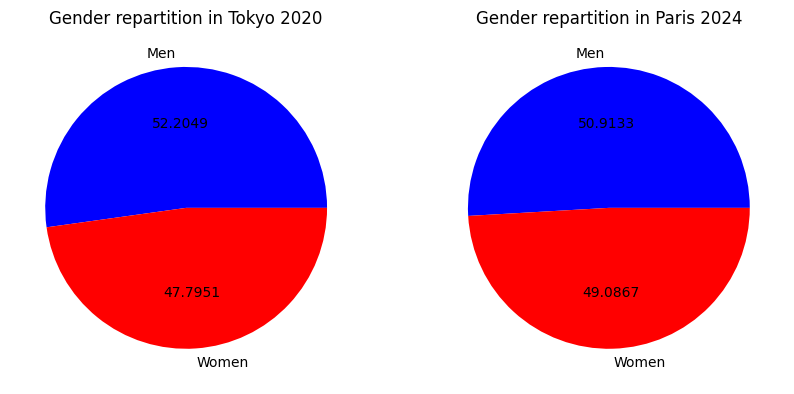

In [139]:
labels = ['Men','Women']
fig,axs = plt.subplots(1,2,figsize=(10,20))
axs[0].pie(x = nb_tokyo,labels = labels,autopct='%.4f',colors=['blue','red'])
axs[0].set_title('Gender repartition in Tokyo 2020')
axs[1].pie(x = nb_paris,labels = labels,autopct='%.4f',colors=['blue','red'])
axs[1].set_title('Gender repartition in Paris 2024')

In [140]:
#On calcule les proportions respectives pour chaque pays.
ratio_athletes_tokyo = (athletes_tokyo_df[['gender','country_code']].groupby('country_code')['gender']
                                        .value_counts(normalize=True)
                                        .unstack('gender', fill_value=0)
                                        .round(3)
                                        .mul(100)
)
#Unstack met le champs suivant à 'gender', on l'enlève pour obtenir un dataframe propre.
ratio_athletes_tokyo.columns.name = None

ratio_athletes_paris = (athletes_paris_df[['gender','country_code']].groupby('country_code')['gender']
                                        .value_counts(normalize=True)
                                        .unstack('gender', fill_value=0)
                                        .round(3)
                                        .mul(100)
)
ratio_athletes_paris.columns.name = None

ratio_athletes = pd.merge(ratio_athletes_tokyo,ratio_athletes_paris,on='country_code',suffixes=['_tokyo','_paris'])

On va en particulier afficher les proportions pour les 20 premiers pays en terme de nombre de participants lors des JO de Paris.

In [141]:
ratio_athletes = pd.merge(ratio_athletes, values, on='country_code')
ratio_athletes.sort_values(by='name_paris',ascending=False,inplace=True)

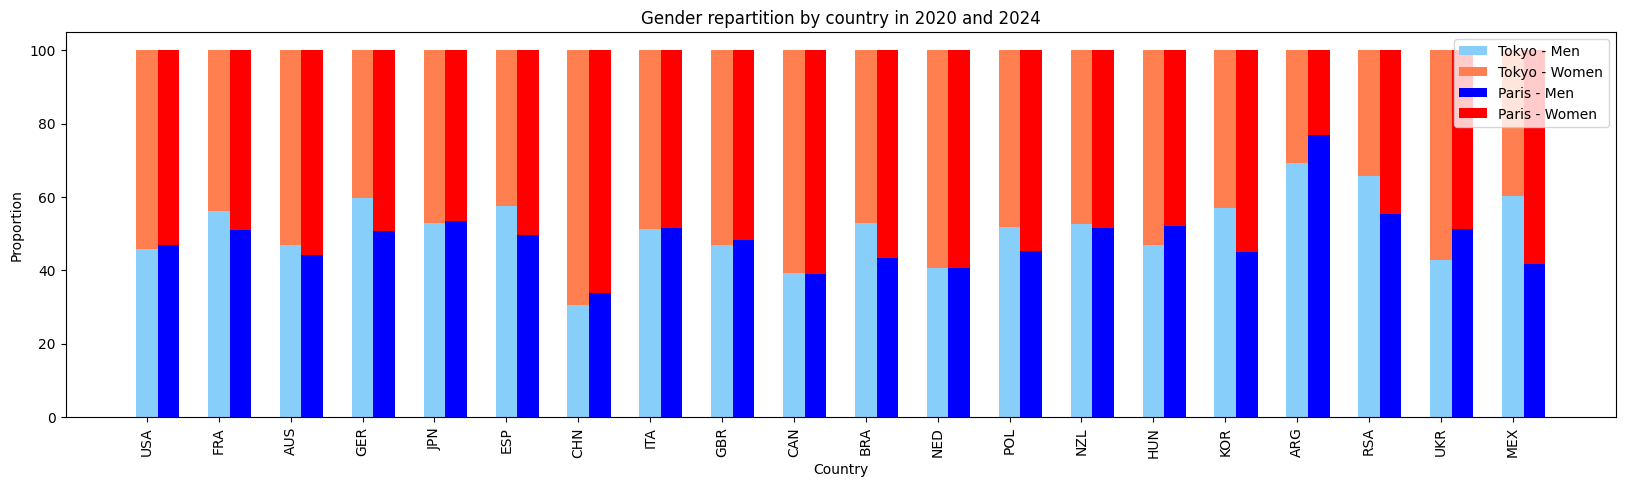

In [142]:
index = np.arange(len(ratio_athletes.index))
bar_width = 0.3

plt.figure(figsize=(20,5))
plt.bar(index, ratio_athletes['Male_tokyo'], width=bar_width, color='lightskyblue', label='Tokyo - Men')
plt.bar(index, ratio_athletes['Female_tokyo'], width=bar_width, color='coral', label='Tokyo - Women', bottom=ratio_athletes['Male_tokyo'])
plt.bar(index+bar_width, ratio_athletes['Male_paris'], width=bar_width, color='blue', label='Paris - Men')
plt.bar(index+bar_width, ratio_athletes['Female_paris'], width=bar_width, color='red', label='Paris - Women', bottom=ratio_athletes['Male_paris'])
plt.xticks(index,ratio_athletes.index,rotation='vertical')
plt.legend()
plt.xlabel('Country')
plt.ylabel('Proportion')
plt.title('Gender repartition by country in 2020 and 2024')
plt.show()

In [143]:
medals_total_tokyo_raw = pd.read_csv(f'{DATA_ROOT}/DataTokyo/medals_total.csv')
medals_total_paris_raw = pd.read_csv(f'{DATA_ROOT}/DataParis/medals_total.csv')

## Etude du pourcentage d'athlètes médaillés en fonction du nombre de disciplines médaillées par pays

Nous allons maintenant étudier la relation entre le pourcentage d'athlètes médaillés et le nombre de disciplines médaillées pour chaque pays. Pour ce faire, nous commençons par calculer chacune des deux métriques dans un dataframe pour les deux JO en utilisant medals.csv pour obtenir les disciplines médaillées et le nombre d'athlète médaillés et athletes.csv pour obtenir le nombre d'athlètes total et en groupant par le pays avec groupby.

In [144]:
def calculer_df(medailles, athletes):
    nb_disciplines = medailles.groupby('country')['discipline'].apply(set).apply(len).rename('nb_disciplines')
    nb_athletes_medailles = medailles.groupby('country')['athlete_name'].apply(set).apply(len).rename('nb_athletes_medailles')
    nb_athletes = athletes.groupby('country')['name'].apply(set).apply(len).rename('nb_athletes')

    df = pd.concat([nb_disciplines, nb_athletes, nb_athletes_medailles], axis=1).fillna(0)
    df['ratio'] = df['nb_athletes_medailles'] / df['nb_athletes']
    df = df.drop(df[df['ratio'] == 0].index)
    return df

medals_tokyo = pd.read_csv(f'{DATA_ROOT}/DataTokyo/medals.csv')
athletes_tokyo = pd.read_csv(f'{DATA_ROOT}/DataTokyo/athletes.csv')

medals_paris = pd.read_csv(f'{DATA_ROOT}/DataParis/medals.csv').rename(columns={'name': 'athlete_name'})
athletes_paris = pd.read_csv(f'{DATA_ROOT}/DataParis/athletes.csv')

df_tokyo = calculer_df(medals_tokyo, athletes_tokyo)
df_paris = calculer_df(medals_paris, athletes_paris)

Ensuite, nous pouvons afficher le graphique du pourcentage d'athlètes médaillés en fonction du nombre de disciplines médaillées pour chaque pays.

In [145]:
def plot_df(df):
    plt.figure(figsize=(15, 10))
    plt.scatter(df['nb_disciplines'], df['ratio'])

    for i, country in enumerate(df.index):
        plt.annotate(country, (df['nb_disciplines'].iloc[i]+0.1, df['ratio'].iloc[i]+0.005))

    plt.xlabel('Nombre de disciplines médaillées')
    plt.ylabel('Ratio d\'athlètes médaillés')

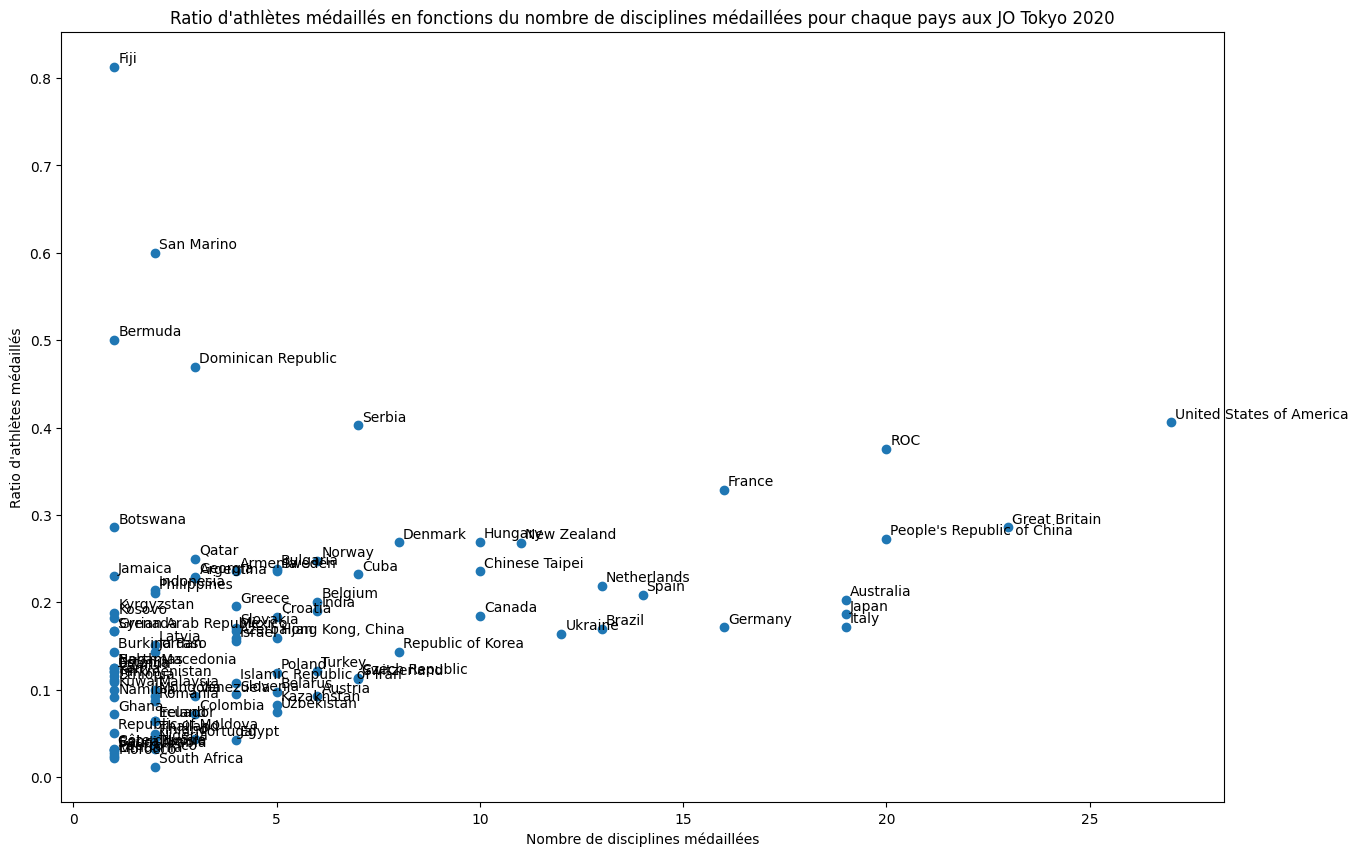

In [146]:
plot_df(df_tokyo)
plt.title('Ratio d\'athlètes médaillés en fonctions du nombre de disciplines médaillées pour chaque pays aux JO Tokyo 2020')
plt.show()

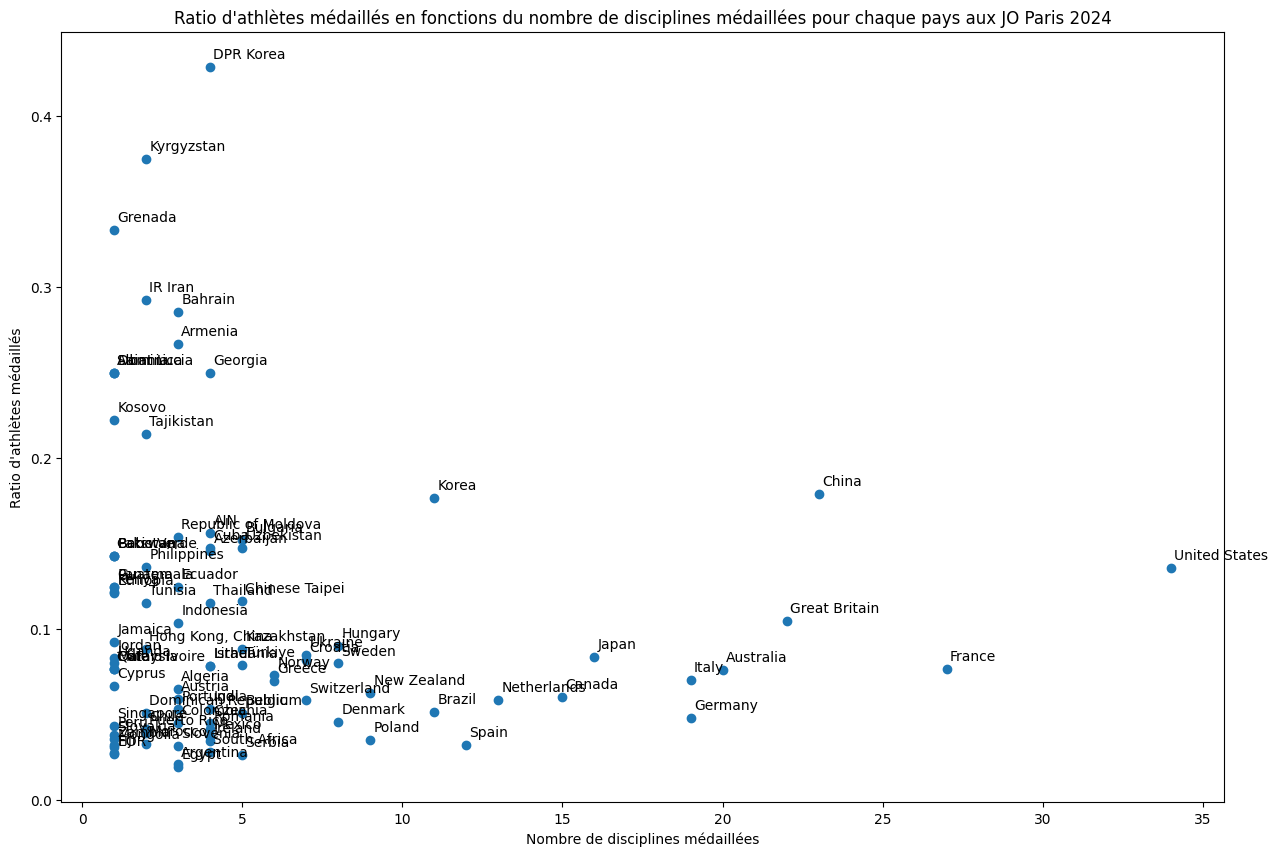

In [147]:
plot_df(df_paris)
plt.title('Ratio d\'athlètes médaillés en fonctions du nombre de disciplines médaillées pour chaque pays aux JO Paris 2024')
plt.show()

Nous pouvons identifier trois groupes principaux dans les graphiques :


*   dans la partie droite : les pays très performant qui ont beaucoup de disciplines médaillées pour une bonne proportion d'athlètes médaillés
*   dans la partie haute à gauche : les pays très spécifiques qui ont très peu de disciplines médaillées mais qui regroupent la plupart de leurs athlètes
*   dans la partie inférieure gauche : les pays qui n'ont pas vraiment brillé aux JO.



Nous allons maintenant utiliser une technique de clustering qui va permettre de confirmer cette analyse. Nous utilisons ici un modèle KMeans, mais nous devons d'abord standardiser nos données car actuellement, l'échelle des disciplines va de 0 à 35 tandis que l'échelle des athlètes médaillés est un pourcentage, donc deux pays sont très beaucoup plus distants horizontalement que verticallement, et on se retrouverait donc avec un découpage vertical. Pour ce faire nous utilisons un StandardScaler qui va standardiser les données en enlevant la moyenne et en divisant par l'écart-type pour avoir une distribution normale centrée-réduite.

In [148]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def get_clusters(df):
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(df[['nb_disciplines', 'ratio']]))
    scaled_data.columns = ['nb_disciplines', 'ratio']
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(scaled_data)
    clusters = df.copy()
    clusters['cluster'] = kmeans.labels_
    return clusters

def describe_clusters(clusters_df):
    for i in range(clusters_df['cluster'].value_counts().count()):
        print('--- cluster {} ({} values) ---'.format(i, clusters_df[clusters_df['cluster'] == i].shape[0]))
        print(clusters_df[clusters_df['cluster'] == i].drop('cluster', axis=1).describe())
        print()

In [149]:
clusters_tokyo = get_clusters(df_tokyo)
describe_clusters(clusters_tokyo)

--- cluster 0 (16 values) ---
       nb_disciplines  nb_athletes  nb_athletes_medailles      ratio
count       16.000000    16.000000              16.000000  16.000000
mean         3.750000    60.750000              17.687500   0.341388
std          2.352304    52.071105              13.597641   0.171882
min          1.000000     2.000000               1.000000   0.227513
25%          1.750000    16.750000               4.000000   0.234442
50%          3.000000    51.500000              15.000000   0.248656
75%          5.250000    88.500000              29.500000   0.419148
max          8.000000   189.000000              43.000000   0.812500

--- cluster 1 (17 values) ---
       nb_disciplines  nb_athletes  nb_athletes_medailles      ratio
count            17.0    17.000000              17.000000  17.000000
mean             16.0   354.117647              87.941176   0.242058
std               5.0   148.774528              55.273717   0.073997
min              10.0    68.000000        

In [150]:
clusters_paris = get_clusters(df_paris)
describe_clusters(clusters_paris)

--- cluster 0 (69 values) ---
       nb_disciplines  nb_athletes  nb_athletes_medailles      ratio
count       69.000000    69.000000              69.000000  69.000000
mean         3.550725    75.289855               5.086957   0.078682
std          2.575542    58.525033               4.391634   0.042146
min          1.000000     7.000000               1.000000   0.019355
25%          1.000000    29.000000               2.000000   0.041667
50%          3.000000    60.000000               4.000000   0.076923
75%          5.000000   109.000000               7.000000   0.115385
max         11.000000   290.000000              26.000000   0.176871

--- cluster 1 (11 values) ---
       nb_disciplines  nb_athletes  nb_athletes_medailles      ratio
count       11.000000    11.000000              11.000000  11.000000
mean        20.000000   430.909091              37.181818   0.084192
std          6.434283   103.671071              22.404545   0.042012
min         12.000000   290.000000        

Nous observons les mêmes caractéristiques que l'analyse précédente dans les trois clusters de chaque JO. Il suffit seulement maintenant d'attribuer le même numéro pour chaque type de cluster.

In [151]:
clusters_paris['cluster'] = clusters_paris['cluster'].map(lambda x: 0 if x == 2 else 2 if x == 0 else x)

Nous affichons maintenant les clusters des deux JO sur le même graphique pour pouvoir voir les différences.

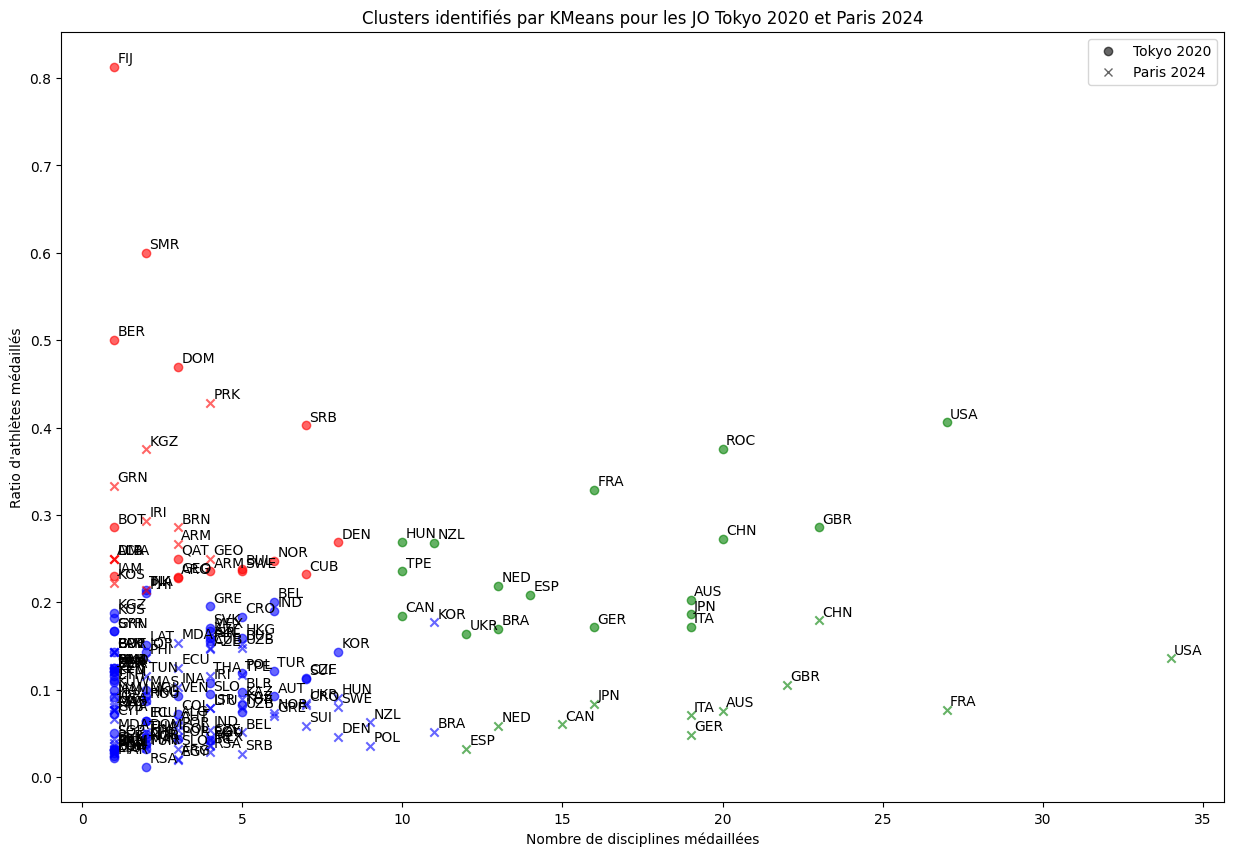

In [152]:
import matplotlib.lines as mlines

def scatter_clusters(df, marker):
    top = df[df['cluster'] == 0]
    right = df[df['cluster'] == 1]
    middle = df[df['cluster'] == 2]

    plt.scatter(top['nb_disciplines'], top['ratio'], color='red', marker=marker, alpha=0.6)
    plt.scatter(right['nb_disciplines'], right['ratio'], color='green', marker=marker, alpha=0.6)
    plt.scatter(middle['nb_disciplines'], middle['ratio'], color='blue', marker=marker, alpha=0.6)


plt.figure(figsize=(15, 10))

scatter_clusters(clusters_tokyo, 'o')
scatter_clusters(clusters_paris, 'x')

country_codes_tokyo = pd.read_csv(f'{DATA_ROOT}/DataTokyo/medals.csv').set_index('country')['country_code'].drop_duplicates()
country_codes_paris = pd.read_csv(f'{DATA_ROOT}/DataParis/medals.csv').set_index('country')['country_code'].drop_duplicates()

for i, country_code in enumerate(clusters_tokyo.index):
    plt.annotate(country_codes_tokyo.loc[country_code], (clusters_tokyo['nb_disciplines'].iloc[i]+0.1, clusters_tokyo['ratio'].iloc[i]+0.005))

for i, country_code in enumerate(clusters_paris.index):
    plt.annotate(country_codes_paris.loc[country_code], (clusters_paris['nb_disciplines'].iloc[i]+0.1, clusters_paris['ratio'].iloc[i]+0.005))

circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', alpha=0.6, label='Tokyo 2020')
cross = mlines.Line2D([], [], color='black', marker='x', linestyle='None', alpha=0.6, label='Paris 2024')

plt.legend(handles=[circle, cross])
plt.title('Clusters identifiés par KMeans pour les JO Tokyo 2020 et Paris 2024')
plt.xlabel('Nombre de disciplines médaillées')
plt.ylabel('Ratio d\'athlètes médaillés')
plt.show()

Enfin, la matrice de confusion est un autre moyen pour identifier les différences dans les clusters et les pays qui ont pu se déplacer d'un cluster à l'autre. Nous remarquons que seulement deux pays sont restés dans le cluster supérieur (numéro 0) entre les deux JO, et 37 pays n'ont pas bougé du cluster général (numéro 2).

In [153]:
pd.crosstab(clusters_tokyo['cluster'].rename('Tokyo'), clusters_paris['cluster'].rename('Paris'))

Paris,0,1,2
Tokyo,,,
0,2,0,12
1,0,9,5
2,4,0,37


# II. Prediction du nombre de médailles par pays

## Evolution du classement des médailles par pays

In [154]:
medals_total_tokyo_raw = pd.read_csv(f'{DATA_ROOT}/DataTokyo/medals_total.csv')
medals_total_paris_raw = pd.read_csv(f'{DATA_ROOT}/DataParis/medals_total.csv')

On doit tout d'abord mettre en forme nos données pour les exploiter plus aisément. La forme finale des deux dataframe est la suivante : `country_code`, `country_name`, `rank`, `gold_medal_count`, `silver_medal_count`, `bronze_medal_count`

In [155]:
medals_total_tokyo_rows = []
for index, row in medals_total_tokyo_raw.iterrows():
  newRow = [row['Country Code'], None, row['Rank'], row['Gold Medal'], row['Silver Medal'], row['Bronze Medal'], None]

  country_name_candidate = [v for v in medals_total_paris_raw[medals_total_paris_raw['country_code'] == newRow[0]]['country_long']]
  if len(country_name_candidate) > 0:
    newRow[1] = country_name_candidate[0]

  newRow[6] = newRow[3] + newRow[4] + newRow[5]

  medals_total_tokyo_rows.append(newRow)

medals_total_tokyo = pd.DataFrame(data=medals_total_tokyo_rows, columns=['country_code', 'country_name', 'rank', 'gold_medal_count', 'silver_medal_count', 'bronze_medal_count', 'all_medal_count'])
medals_total_tokyo.set_index('country_code', inplace=True)

#

medals_total_paris_rows = []
for index, row in medals_total_paris_raw.iterrows():
  medals_total_paris_rows.append([row['country_code'], row['country_long'], index+1, row['Gold Medal'], row['Silver Medal'], row['Bronze Medal'], row['Total']])

medals_total_paris = pd.DataFrame(data=medals_total_paris_rows, columns=['country_code', 'country_name', 'rank', 'gold_medal_count', 'silver_medal_count', 'bronze_medal_count', 'all_medal_count'])
medals_total_paris.set_index('country_code', inplace=True)

On aimerait aussi pouvoir choisir entre exclure les pays n'ayant pas participé aux JO de Tokyo et/ou à ceux de Paris:

In [156]:
def sync_medal_total_data(
  exclude_tokyo_non_participating_countries,
  exclude_paris_non_participating_countries
):
  medals_total_tokyo_copy = medals_total_tokyo.copy()
  medals_total_paris_copy = medals_total_paris.copy()

  medals_total_tokyo_index_copy = medals_total_tokyo_copy.index.copy()
  medals_total_paris_index_copy = medals_total_paris_copy.index.copy()

  #

  for country_code in medals_total_tokyo_index_copy:
    if country_code not in medals_total_paris_copy.index:
      if exclude_paris_non_participating_countries:
        medals_total_tokyo_copy.drop([country_code], inplace=True)
      else:
        medals_total_paris_copy.loc[country_code] = [medals_total_tokyo_copy.loc[country_code]['country_name'], len(medals_total_paris_copy)+1, 0, 0, 0, 0]

  #

  for country_code in medals_total_paris_index_copy:
    if country_code not in medals_total_tokyo_copy.index:
      if exclude_tokyo_non_participating_countries:
        medals_total_paris_copy.drop([country_code], inplace=True)
      else:
        medals_total_tokyo_copy.loc[country_code] = [medals_total_paris_copy.loc[country_code]['country_name'], len(medals_total_tokyo_copy)+1, 0, 0, 0, 0]

  #

  medals_total_tokyo_copy = medals_total_tokyo_copy.reset_index(inplace=False).sort_values(by='country_code', inplace=False).set_index('country_code', inplace=False)
  medals_total_paris_copy = medals_total_paris_copy.reset_index(inplace=False).sort_values(by='country_code', inplace=False).set_index('country_code', inplace=False)

  #

  return (medals_total_tokyo_copy, medals_total_paris_copy)

##### Fonctions de visualisation

In [157]:
def __draw_medal_total_barplot_by_medal_type__(
  barplot_mapper,
  orientation=None,
  exclude_tokyo_non_participating_countries=True,
  exclude_paris_non_participating_countries=True,
  title='',
  figsize=None
):
  orientation = orientation if orientation else "vertical"

  medals_total_tokyo_copy, medals_total_paris_copy = sync_medal_total_data(exclude_tokyo_non_participating_countries, exclude_paris_non_participating_countries)

  if figsize is None:
    figsize = (10, 6)

  fig, ax = plt.subplots(figsize=((figsize[1], figsize[0]) if orientation == "horizontal" else figsize))


  print(barplot_mapper)
  medals_total_tokyo_copy, medals_total_paris_copy = barplot_mapper((plt.barh if orientation == "horizontal" else plt.bar), medals_total_tokyo_copy, medals_total_paris_copy)

  indexes = []
  for index, row in medals_total_tokyo_copy.iterrows():
    indexes.append(str(row['country_name'] if row['country_name'] else index) + " (" + str(index) + ")")

  (ax.set_yticks if orientation == "horizontal" else ax.set_xticks)(np.arange(len(medals_total_paris_copy.index)), indexes, rotation=orientation)

  (ax.set_ylabel if orientation == "horizontal" else ax.set_xlabel)("Country")
  (ax.set_xlabel if orientation == "horizontal" else ax.set_ylabel)("Medal count")

  (ax.axvline if orientation == "horizontal" else ax.axhline)(0, color='black')

  ax.set_title(title)
  plt.legend()

  ax.grid(color='black', linestyle='-', linewidth=0.25)

  return fig, ax

In [158]:
def keep_dataframe_order_by(dfsource, dftarget, column):
  dftarget.reset_index(inplace=True)

  dftarget[column] = dftarget[column].astype("category")
  dftarget[column] = dftarget[column].cat.set_categories(dfsource.index, ordered=True)

  dftarget.sort_values([column], inplace=True)
  dftarget[column] = dftarget[column].astype(str)

  dftarget.set_index(column, inplace=True)

#

def draw_medal_total_comparison_barplot(
  orientation=None,
  exclude_tokyo_non_participating_countries=True,
  exclude_paris_non_participating_countries=True,
  country_codes=None,
  title='',
  figsize=None
):
  def barplot_mapper(barplot_method, medals_total_tokyo_copy, medals_total_paris_copy):
    if country_codes is not None:
      medals_total_tokyo_copy = medals_total_tokyo_copy.loc[[c for c in country_codes if c in medals_total_tokyo_copy.index]].copy().reset_index().set_index('country_code')
      medals_total_paris_copy = medals_total_paris_copy.loc[[c for c in country_codes if c in medals_total_paris_copy.index]].copy().reset_index().set_index('country_code')

    medals_total_tokyo_copy.sort_values(['gold_medal_count', 'silver_medal_count', 'bronze_medal_count'], ascending=[True, True, True], inplace=True)
    keep_dataframe_order_by(medals_total_tokyo_copy, medals_total_paris_copy, 'country_code')

    #

    offset = 0.2
    width = 0.4

    axis = np.arange(len(medals_total_paris_copy.index))

    bronze_count_tokyo = medals_total_tokyo_copy['bronze_medal_count']
    barplot_method(axis-offset, bronze_count_tokyo, width, color='saddlebrown', label="Bronze medals (Tokyo)")
    silver_count_tokyo = medals_total_tokyo_copy['silver_medal_count']
    barplot_method(axis-offset, silver_count_tokyo, width, bottom=bronze_count_tokyo, color='gray', label="Silver medals (Tokyo)")
    gold_count_tokyo = medals_total_tokyo_copy['gold_medal_count']
    barplot_method(axis-offset, gold_count_tokyo, width, bottom=bronze_count_tokyo+silver_count_tokyo, color='orange', label="Gold medals (Tokyo)")

    bronze_count_paris = medals_total_paris_copy['bronze_medal_count']
    barplot_method(axis+offset, bronze_count_paris, width, color='peru', label="Bronze medals (Paris)")
    silver_count_paris = medals_total_paris_copy['silver_medal_count']
    barplot_method(axis+offset, silver_count_paris, width, bottom=bronze_count_paris, color='silver', label="Silver medals (Paris)")
    gold_count_paris = medals_total_paris_copy['gold_medal_count']
    barplot_method(axis+offset, gold_count_paris, width, bottom=bronze_count_paris+silver_count_paris, color='gold', label="Gold medals (Paris)")

    return medals_total_tokyo_copy, medals_total_paris_copy

  #

  return __draw_medal_total_barplot_by_medal_type__(barplot_mapper, orientation, exclude_tokyo_non_participating_countries, exclude_paris_non_participating_countries, title=title, figsize=figsize)

#

def draw_medal_total_difference_barplot_by_medal_type(
  orientation=None,
  exclude_tokyo_non_participating_countries=True,
  exclude_paris_non_participating_countries=True,
  country_codes=None,
  title='',
  figsize=None
):
  def barplot_mapper(barplot_method, medals_total_tokyo_copy, medals_total_paris_copy):
    if country_codes is not None:
      medals_total_tokyo_copy = medals_total_tokyo_copy.loc[[c for c in country_codes if c in medals_total_tokyo_copy.index]].copy().reset_index().set_index('country_code')
      medals_total_paris_copy = medals_total_paris_copy.loc[[c for c in country_codes if c in medals_total_paris_copy.index]].copy().reset_index().set_index('country_code')

    medals_total_tokyo_copy.sort_values(['gold_medal_count', 'silver_medal_count', 'bronze_medal_count'], ascending=[True, True, True], inplace=True)
    keep_dataframe_order_by(medals_total_tokyo_copy, medals_total_paris_copy, 'country_code')

    #

    width = 0.4

    axis = np.arange(len(medals_total_paris_copy.index))

    bronze_diff = medals_total_paris_copy['bronze_medal_count'] - medals_total_tokyo_copy['bronze_medal_count']
    barplot_method(axis, bronze_diff, width, color='peru', label="Bronze medals (Tokyo)")
    silver_diff = medals_total_paris_copy['silver_medal_count'] - medals_total_tokyo_copy['silver_medal_count']
    barplot_method(axis, silver_diff, width, bottom=bronze_diff, color='silver', label="Silver medals (Tokyo)")
    gold_diff = medals_total_paris_copy['gold_medal_count'] - medals_total_tokyo_copy['gold_medal_count']
    barplot_method(axis, gold_diff, width, bottom=bronze_diff+silver_diff, color='gold', label="Gold medals (Tokyo)")

    return medals_total_tokyo_copy, medals_total_paris_copy

  #

  return __draw_medal_total_barplot_by_medal_type__(barplot_mapper, orientation, exclude_tokyo_non_participating_countries, exclude_paris_non_participating_countries, title=title, figsize=figsize)

#### Visualisation

<function draw_medal_total_comparison_barplot.<locals>.barplot_mapper at 0x7c05bbba0160>


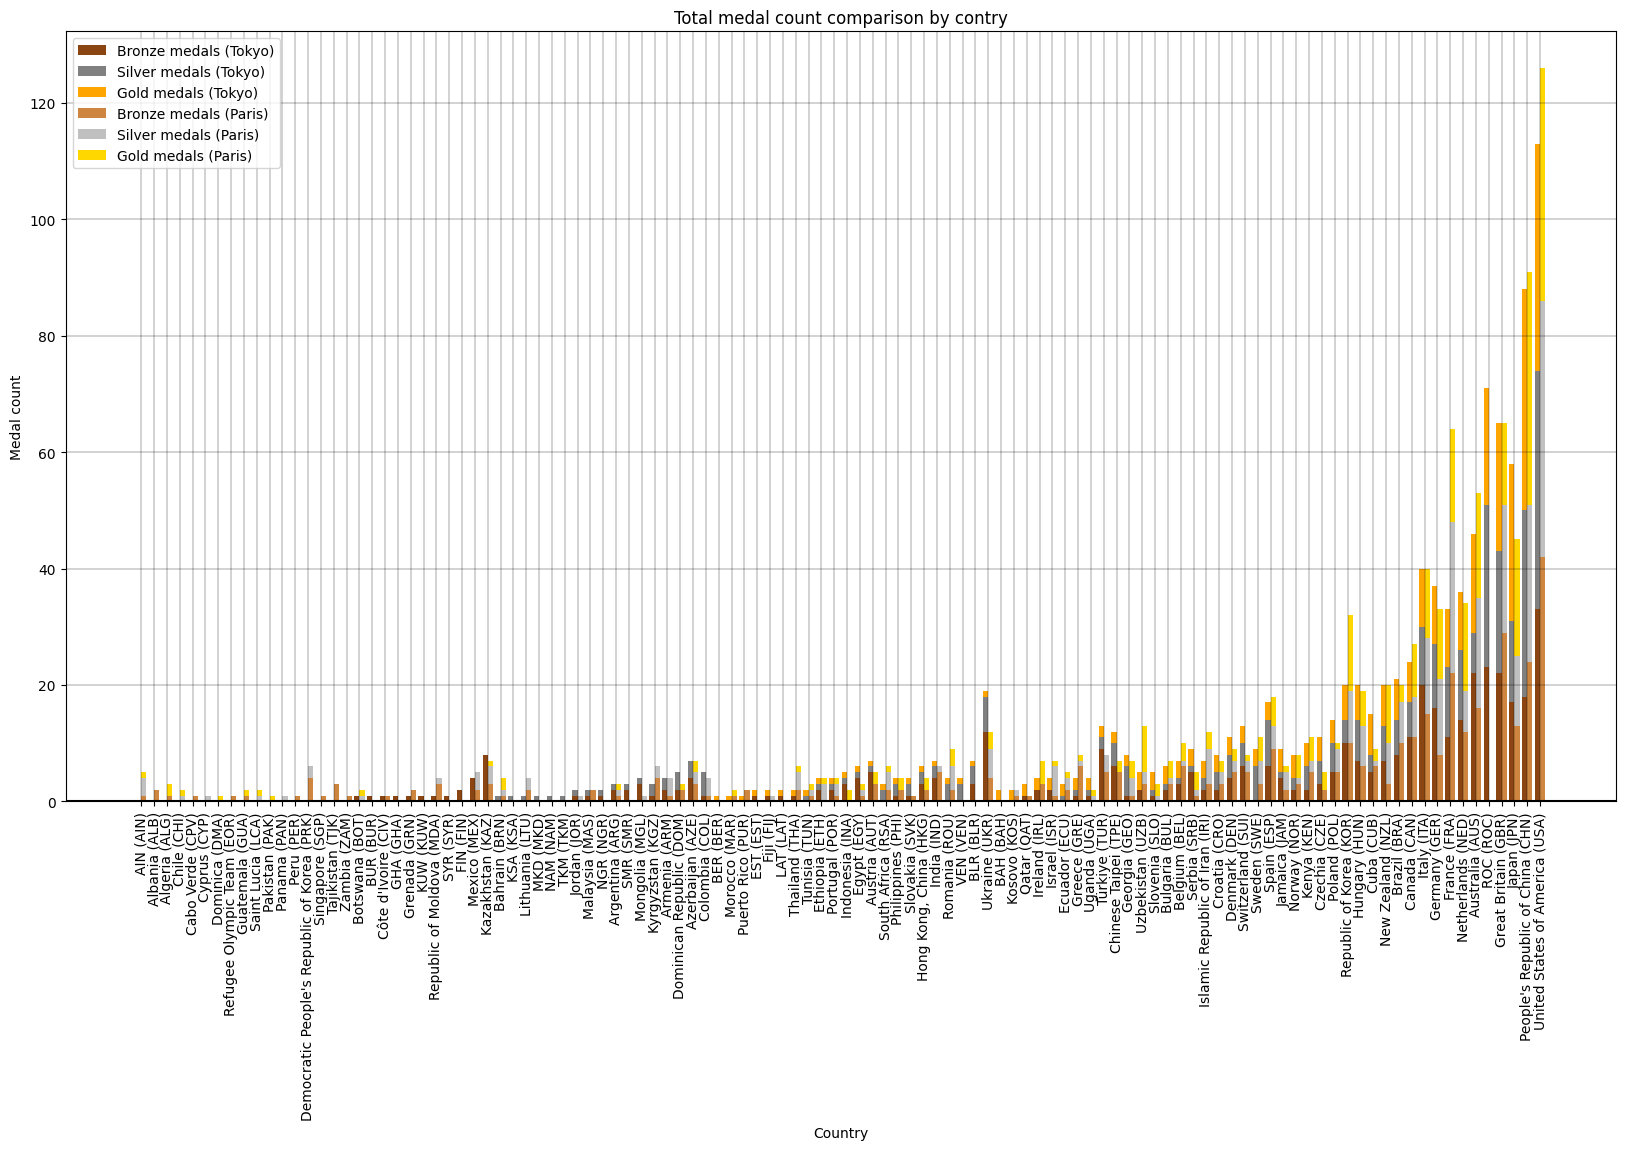

In [159]:
draw_medal_total_comparison_barplot(title='Total medal count comparison by contry', figsize=(20, 10), exclude_tokyo_non_participating_countries=False, exclude_paris_non_participating_countries=False)
plt.show()

<function draw_medal_total_difference_barplot_by_medal_type.<locals>.barplot_mapper at 0x7c05bc2c5bd0>


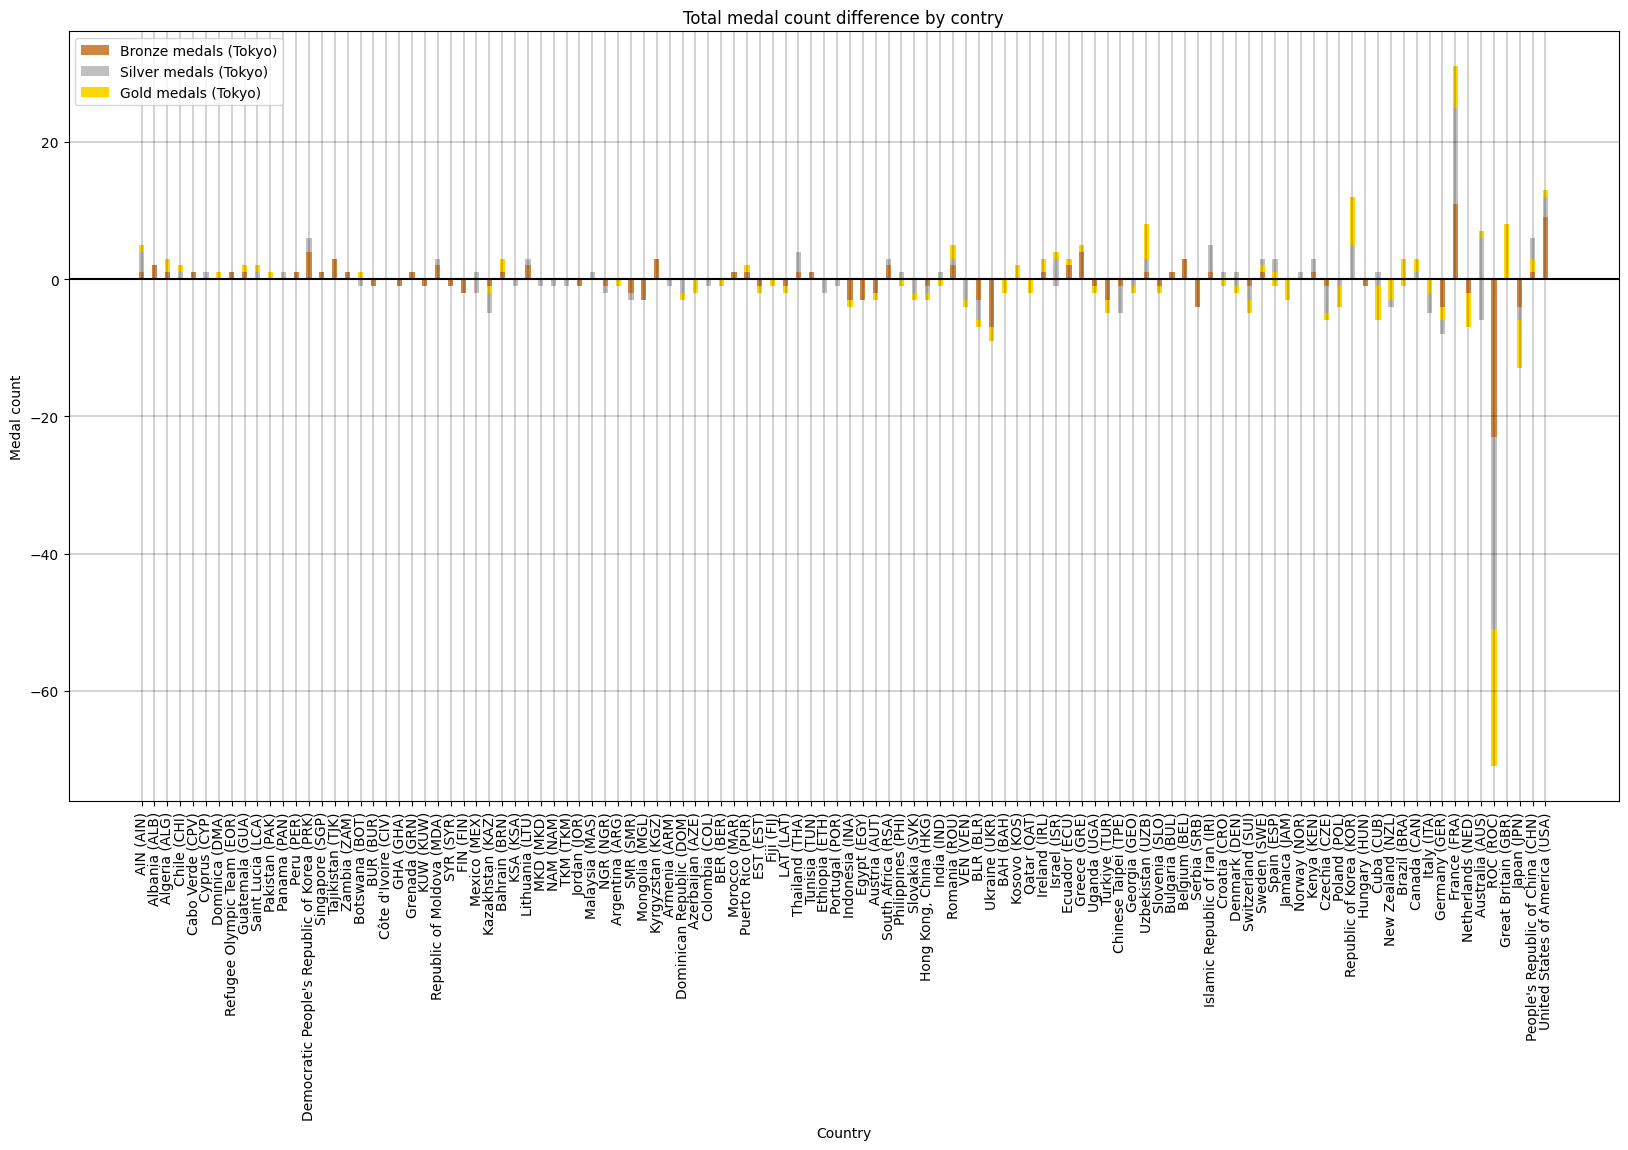

In [160]:
draw_medal_total_difference_barplot_by_medal_type(title='Total medal count difference by contry', figsize=(20, 10), exclude_tokyo_non_participating_countries=False, exclude_paris_non_participating_countries=False)
plt.show()

#### Influence du pays hôte

<function draw_medal_total_comparison_barplot.<locals>.barplot_mapper at 0x7c05bc2a1c60>


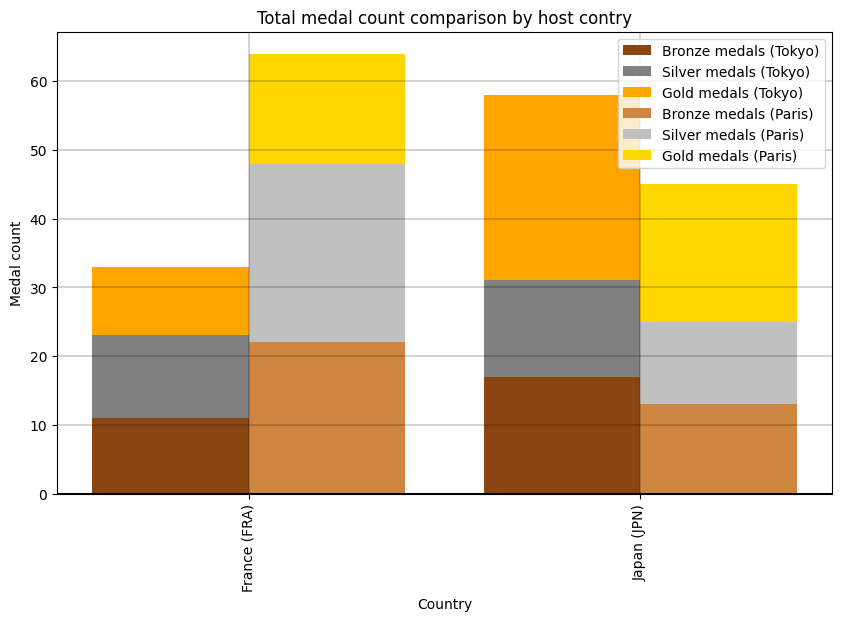

In [161]:
draw_medal_total_comparison_barplot(title='Total medal count comparison by host contry', figsize=(10, 6), exclude_tokyo_non_participating_countries=False, exclude_paris_non_participating_countries=False, country_codes=['JPN', 'FRA'])
plt.show()

On constate que la France est le pays ayant connu la plus grande augmentation de son nombre total de médailles entre les JO de Tokyo et ceux de Paris. Le facteur qui pourrait expliquer cette différence est que la France était le pays hôte des JO de Paris.

Le japon, pays hôte des JO de Tokyo, ayant eu la plus grande diminution de médailles, cela semble corroborer l'hypothèse selon laquelle le pays hôte est avantagé / est meilleur à domicile.

#### Impact de la non-participation de la Russie

L'impact de la non-participation de la Russie au JO de Paris peut se mesurer en partie à travers l'évolution global du nombre de médailles par pays.

Pour cela, on peut regarder la somme des différences de médailles par pays entre les jeux de Paris et ceux de Tokyo en excluant la Russie. Ainsi, si le résultat est positif, cela signifiera que les pays ont globalement gagné des médailles par rapport aux jeux de Tokyo et au contraire, si le résultat est négatif, ils auront globalement perdu des médailles.

In [162]:
medals_total_tokyo_copy, medals_total_paris_copy = sync_medal_total_data(False, False)

medals_total_tokyo_copy.drop(['ROC'], inplace=True)
medals_total_paris_copy.drop(['ROC'], inplace=True)

diff_sum_roc_excluded = (medals_total_paris_copy['all_medal_count'] - medals_total_tokyo_copy['all_medal_count']).sum()
print('differences sum (ROC excluded):', diff_sum_roc_excluded)

differences sum (ROC excluded): 34.0


Ainsi, on constate que l'ensemble des pays semble a connu une hausse globale de `34` médailles au total lors des JO de Paris.

## Comment la  répartition des médailles entre les continents a-t-elle évolué  entre 2020 et 2024 ? Y a-t-il des continents qui ont amélioré leurs  performances globales ?

In [163]:
pays_continents = {
    'USA': 'North America',
    'CHN': 'Asia',
    'JPN': 'Asia',
    'GBR': 'Europe',
    'ROC': 'Asia', # à vérifier
    'AUS': 'Oceania',
    'NED': 'Europe',
    'FRA': 'Europe',
    'GER': 'Europe',
    'ITA': 'Europe',
    'CAN': 'North America',
    'BRA': 'South America',
    'NZL': 'Oceania',
    'CUB': 'North America',
    'HUN': 'Europe',
    'KOR': 'Asia',
    'POL': 'Europe',
    'CZE': 'Europe',
    'KEN': 'Africa',
    'NOR': 'Europe',
    'JAM': 'Africa',
    'ESP': 'Europe',
    'SWE': 'Europe',
    'SUI': 'Europe',
    'DEN': 'Europe',
    'CRO': 'Europe',
    'IRI': 'Africa',
    'SRB': 'Europe',
    'BEL': 'Europe',
    'BUL': 'Europe',
    'SLO': 'Europe',
    'UZB': 'Asia',
    'GEO': 'Europe',
    'TPE': 'Asia',
    'TUR': 'Europe',
    'GRE': 'Europe',
    'UGA': 'Africa',
    'ECU': 'South America',
    'IRL': 'Europe',
    'ISR': 'Asia',
    'QAT': 'Asia',
    'BAH': 'North America',
    'KOS': 'Europe',
    'UKR': 'Europe',
    'BLR': 'Europe',
    'ROU': 'Europe',
    'VEN': 'South America',
    'IND': 'Asia',
    'HKG': 'Asia',
    'PHI': 'Asia',
    'SVK': 'Europe',
    'RSA': 'Africa',
    'AUT': 'Europe',
    'EGY': 'Africa',
    'INA': 'Asia',
    'ETH': 'Africa',
    'POR': 'Europe',
    'TUN': 'Africa',
    'EST': 'Europe',
    'FIJ': 'Oceania',
    'LAT': 'Europe',
    'THA': 'Asia',
    'BER': 'North America',
    'MAR': 'Africa',
    'PUR': 'North America',
    'COL': 'South America',
    'AZE': 'Europe',
    'DOM': 'North America',
    'ARM': 'Europe',
    'KGZ': 'Asia',
    'MGL': 'Asia',
    'ARG': 'South America',
    'SMR': 'Europe',
    'JOR': 'Asia',
    'MAS': 'Asia',
    'NGR': 'Africa',
    'BRN': 'Asia',
    'KSA': 'Asia',
    'LTU': 'Europe',
    'MKD': 'Europe',
    'NAM': 'Africa',
    'TKM': 'Asia',
    'KAZ': 'Asia',
    'MEX': 'North America',
    'FIN': 'Europe',
    'BOT': 'Africa',
    'BUR': 'Africa',
    'CIV': 'Africa',
    'GHA': 'Africa',
    'GRN': 'North America',
    'KUW': 'Asia',
    'MDA': 'Europe',
    'SYR': 'Asia',
    'TJK': 'Europe',
    'GUA': 'North America',
    'PRK': 'Asia',
    'LCA': 'North America',
    'DMA': 'North America',
    'ALG': 'Africa',
    'CPV': 'Africa',
    'CHI': 'South America',
    'ZAM': 'Africa',
    'CYP': 'Europe',
    'PER': 'South America',
    'PAK': 'Asia',
    'SGP': 'Asia',
    'PAN': 'North America',
    'ALB': 'Europe'
}

continents_df = pd.DataFrame({'continent': pays_continents.values()}, index=pays_continents.keys())
continents_df.value_counts()

,count
continent,
Europe,41
Asia,26
Africa,18
North America,13
South America,7
Oceania,3


In [164]:
medals_total_tokyo = pd.read_csv(f'{DATA_ROOT}/DataTokyo/medals_total.csv')
medals_total_paris = pd.read_csv(f'{DATA_ROOT}/DataParis/medals_total.csv')

medals_total_tokyo['continent'] = medals_total_tokyo['Country Code'].map(pays_continents)
medals_total_paris['continent'] = medals_total_paris['country_code'].map(pays_continents)

medals_per_continent_tokyo = medals_total_tokyo.groupby('continent')[['Gold Medal', 'Silver Medal', 'Bronze Medal', 'Total']].apply(sum)
medals_per_continent_paris = medals_total_paris.groupby('continent')[['Gold Medal', 'Silver Medal', 'Bronze Medal', 'Total']].apply(sum)

<ipython-input-164-db298cf7a4df>:7: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  medals_per_continent_tokyo = medals_total_tokyo.groupby('continent')[['Gold Medal', 'Silver Medal', 'Bronze Medal', 'Total']].apply(sum)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
<ipython-input-164-db298cf7a4df>:8: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  medals_per_c

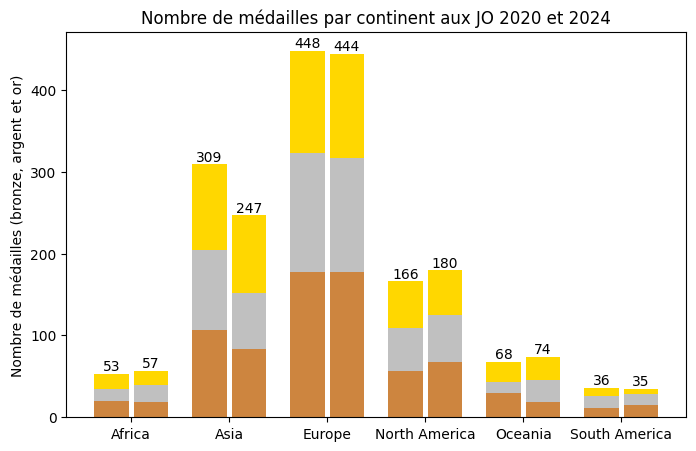

In [165]:
space = 2
offset = 0.4
width = 0.7

plt.figure(figsize=(8, 5))
for x, continent in enumerate(medals_per_continent_tokyo.index):
    bronze_tokyo = medals_per_continent_tokyo.loc[continent, 'Bronze Medal']
    silver_tokyo = medals_per_continent_tokyo.loc[continent, 'Silver Medal']
    gold_tokyo = medals_per_continent_tokyo.loc[continent, 'Gold Medal']
    total_tokyo = medals_per_continent_tokyo.loc[continent, 'Total']

    plt.bar(x*space-offset, bronze_tokyo, color='peru', width = width)
    plt.bar(x*space-offset, silver_tokyo, bottom=bronze_tokyo, color='silver', width = width)
    bar = plt.bar(x*space-offset, gold_tokyo, bottom=bronze_tokyo+silver_tokyo, color='gold', width = width)
    plt.bar_label(bar)

    bronze_paris = medals_per_continent_paris.loc[continent, 'Bronze Medal']
    silver_paris = medals_per_continent_paris.loc[continent, 'Silver Medal']
    gold_paris = medals_per_continent_paris.loc[continent, 'Gold Medal']
    total_paris = medals_per_continent_paris.loc[continent, 'Total']

    plt.bar(x*space+offset, bronze_paris, color='peru', width = width)
    plt.bar(x*space+offset, silver_paris, bottom=bronze_paris, color='silver', width = width)
    bar = plt.bar(x*space+offset, gold_paris, bottom=bronze_paris+silver_paris, color='gold', width = width)
    plt.bar_label(bar)

plt.title('Nombre de médailles par continent aux JO 2020 et 2024')
plt.ylabel('Nombre de médailles (bronze, argent et or)')
plt.xticks([x*space for x in range(len(medals_per_continent_tokyo.index))], medals_per_continent_tokyo.index)
plt.show()

On peut supposer que la différence pour l'Asie est dûe au nombre de médailles du Japon, inférieur en 2024, ainsi qu'à la non-participation de la Russie. En revanche, malgré l'augmentation notable du nombre de médailles de la France, le total de l'Europe ne varie pratiquement pas, de même pour les autres continents.

L'évolution du nombre de médailles par continent n'étant donc pas notable, nous allons nous intéresser à l'évolution du nombre de médailles par pays entre 2020 et 2024. En particulier, peut-on créer un modèle prévoyant les variations observées plus haut ?

## En utilisant les  données de 2020 et les caractéristiques des athlètes, peut-on créer un modèle qui prédit le nombre de médailles par pays pour les JO de 2024 ?


### Traitement des données

Les données fournies pour les JO de Tokyo sur les athlètes étant incomplètes, nous avons choisi de récupérer des données plus complètes et plus simple à exploiter sur le site [Olympedia](https://www.olympedia.org/) (via du web scraping).

Les données des JO de Paris sur les athlètes sont assez similaires, bien qu'il contienne moins d'indicateurs par rapport à celui extrait de Olympedia sur les JO de Tokyo. Aussi, les données sur les JO de Paris ne sont pas encore disponible sur Olympedia, nous travaillerons donc avec les données qui existe déjà en les traitant au mieux afin d'en extraire le plus d'informations utiles.

In [166]:
athlete_event_results_tokyo = pd.read_csv(f'{DATA_ROOT}/data-supp-tokyo/athlete-event-results/global.2020.summer.csv')
athlete_event_results_paris_raw = pd.read_csv(f'{DATA_ROOT}/DataParis/athletes.csv')
medallists_paris = pd.read_csv(f'{DATA_ROOT}/DataParis/medallists.csv')

In [167]:
competition_datetimes_tokyo = [
  datetime.strptime('2021-07-21', '%Y-%m-%d'),
  datetime.strptime('2021-08-08', '%Y-%m-%d')
]

In [168]:
competition_datetimes_paris = [
  datetime.strptime('2024-07-26', '%Y-%m-%d'),
  datetime.strptime('2021-08-11', '%Y-%m-%d')
]

##### Fonctions utiles

In [169]:
def replaceValueByMean(df, value):
  disciplines = pd.unique(df['discipline'])

  for discipline in disciplines:
    discipline_athlete_events_df = df[df['discipline'] == discipline]
    discipline_events = pd.unique(discipline_athlete_events_df['event'])

    for event in discipline_events:
      discipline_event_df = discipline_athlete_events_df[discipline_athlete_events_df['event'] == event]

      for column in ['athlete_height_cm', 'athlete_weight_kg']:
        column_mean = discipline_event_df[column].mean()
        column_mean = df[column].mean() if np.isnan(column_mean) else column_mean

        df.loc[
          (
            (df['discipline'] == discipline)
            & (df['event'] == event)
            & (df[column] == value)
          ),
          column
        ] = column_mean

#

def replaceNanByZero(df):
  for column in ['athlete_height_cm', 'athlete_weight_kg']:
    df.loc[df[column].isna(), column] = 0

#### Données des JO de Tokyo

Pour pouvoir exploiter les données des JO de Tokyo, on doit appliquer quelques étapes de pré-traitement:
- les cases vides de la colonne `athlete_medal` représentent le fait qu'un athlète dans une discipline et un événement donnés n'a pas obtenu de médaille (selon notre source [Olympedia](https://www.olympedia.org/)), on les remplira alors avec la valeur `none`
- les valeurs numériques manquantes dans les colonnes `athlete_height_cm` et `athlete_weight_kg` seront remplacées par la moyenne dans la discipline et l'événement donné, ou par une valeur par défaut (ici `0`)

On vérifiera aussi que les données sont complètes et sans valeur incohérentes (exemple: la colonne `athlete_sex` prend une valeur binaire qui est soit `Male` soit `Female`).

In [170]:
athlete_event_results_tokyo.replace({'athlete_medal': np.nan}, {'athlete_medal': 'none'}, inplace=True)

In [171]:
#replaceValueByMean(athlete_event_results_tokyo, np.nan)
replaceNanByZero(athlete_event_results_tokyo)

In [172]:
# Delete unused features
athlete_event_results_tokyo.drop(columns=['team_id'], inplace=True)

In [173]:
# Check if `country_code` column has empty values
assert len(athlete_event_results_tokyo[(athlete_event_results_tokyo['country_code'].isna())]) == 0

In [174]:
# Check if `athlete_age` column has empty values
assert len(athlete_event_results_tokyo[(athlete_event_results_tokyo['athlete_age'].isna())]) == 0

In [175]:
# Check `athlete_sex` column values integrity
assert len(athlete_event_results_tokyo[(athlete_event_results_tokyo['athlete_sex'] != 'Male') & (athlete_event_results_tokyo['athlete_sex'] != 'Female')]) == 0

##### Sauvegarde du jeu de données

In [176]:
athlete_event_results_tokyo.to_csv(f'{DATA_ROOT}/data-supp-tokyo/athlete-event-results/preprocessed.global.2020.summer.csv', index=False)

#### Données des JO de Paris

On doit maintenant créer des données compatibles avec celles des JO de Tokyo à partir des données qui nous ont été fournies sur les JO de Paris.

Ici, il nous faut recréer un dataframe complet possédant les mêmes informations que le dataset des JO de Tokyo.

##### Reconstruction du jeu de données

Les données des JO de Paris ont une forme incompatible avec celles des JO de Tokyo, notamment pour les disciplines et les événements. On souhaite que notre jeu de données soit formé de telle sorte que chaque ligne est identifiée par le nom et le prénom d'un athlète, son age, la discipline et l'événement. On veut aussi qu'il existe les mêmes types d'information dans les deux jeux de données, on doit donc insérer des colonnes manquantes et en renommer certaines.

In [177]:
athlete_event_results_paris_data = []

#

def extractList(pseudoListStr):
  l = [v.strip() for v in pseudoListStr[1:-1].split(', ')]
  l = [(v[1:] if re.search(r"^('|\")", v) else v) for v in l]
  return [(v[:-1] if re.search(r"('|\")$", v) else v) for v in l]

#

for index, row in athlete_event_results_paris_raw.iterrows():
  disciplines = extractList(row['disciplines'])
  events = extractList(row['events'])

  for discipline in disciplines:
    for event in events:
      row_copy = row.copy()
      row_copy['disciplines'] = discipline.strip()
      row_copy['events'] = event.strip()

      athlete_event_results_paris_data.append(row_copy)

athlete_event_results_paris = pd.DataFrame(athlete_event_results_paris_data, columns=athlete_event_results_paris_raw.columns)

#

athlete_event_results_paris.rename(columns={
    'country': 'country_name',
    'disciplines': 'discipline',
    'events': 'event',
    'birth_date': 'athlete_birthdate',
    'gender': 'athlete_sex',
    'height': 'athlete_height_cm',
    'weight': 'athlete_weight_kg'

}, inplace=True)

#

country_code_column = athlete_event_results_paris.pop('country_code')
athlete_event_results_paris.insert(list(athlete_event_results_paris.columns).index('country_name')+1, 'country_code', country_code_column)

athlete_event_results_paris.insert(list(athlete_event_results_paris.columns).index('event')+1, 'athlete_firstname', '')

athlete_event_results_paris.insert(list(athlete_event_results_paris.columns).index('event')+2, 'athlete_lastname', '')

athlete_event_results_paris.insert(list(athlete_event_results_paris.columns).index('athlete_birthdate')+1, 'athlete_age', 0)

athlete_sex_column = athlete_event_results_paris.pop('athlete_sex')
athlete_event_results_paris.insert(list(athlete_event_results_paris.columns).index('athlete_age')+1, 'athlete_sex', athlete_sex_column)

athlete_height_cm_column = athlete_event_results_paris.pop('athlete_height_cm')
athlete_event_results_paris.insert(list(athlete_event_results_paris.columns).index('athlete_sex')+1, 'athlete_height_cm', athlete_height_cm_column)

athlete_weight_kg_column = athlete_event_results_paris.pop('athlete_weight_kg')
athlete_event_results_paris.insert(list(athlete_event_results_paris.columns).index('athlete_height_cm')+1, 'athlete_weight_kg', athlete_weight_kg_column)

athlete_event_results_paris.insert(len(athlete_event_results_paris.columns), 'athlete_medal', 'none')

##### Ajout des médailles

Dans les données des JO de Paris, celles concernant les médailles gagnées par des athlètes ne sont pas dans le même jeu de données que celui sur les informations des athlètes. On doit donc faire une jointure entre ces deux jeux de données.

In [178]:
print('medal count:', len(medallists_paris), 'unique medal count:', len(medallists_paris.drop_duplicates(['code_athlete', 'discipline', 'event'])))

for index, row in medallists_paris.iterrows():
  athlete_code = row['code_athlete']
  discipline = row['discipline']
  event = row['event']
  medal = row['medal_type'].split(' ')[0].lower()

  discipline_athlete_candidates = athlete_event_results_paris[
    (
      (athlete_event_results_paris['discipline'] == discipline)
      & (athlete_event_results_paris['code'] == athlete_code)
    )
  ]

  if discipline_athlete_candidates.empty:
    raise BaseException(f"Unable to find athlete {athlete_code} in {discipline}.")
  else:
    event_athlete_candidates = discipline_athlete_candidates[
      (discipline_athlete_candidates['event'] == event)
    ]

    if event_athlete_candidates.empty:
      print(f"Unable to find athlete {athlete_code} in {event} of {discipline}. Adding it artificially in dataset.")

      new_row = discipline_athlete_candidates.iloc[0].copy()

      new_row['event'] = event
      new_row['athlete_medal'] = medal

      athlete_event_results_paris.loc[len(athlete_event_results_paris)] = new_row
    else:
      athlete_event_results_paris.loc[
        (
          (athlete_event_results_paris['discipline'] == discipline)
          & (athlete_event_results_paris['event'] == event)
          & (athlete_event_results_paris['code'] == athlete_code)
        ),
        'athlete_medal'
      ] = medal

medal count: 2315 unique medal count: 2315
Unable to find athlete 1558780 in Mixed Relay of Triathlon. Adding it artificially in dataset.
Unable to find athlete 1558784 in Mixed Relay of Triathlon. Adding it artificially in dataset.
Unable to find athlete 1558775 in Mixed Relay of Triathlon. Adding it artificially in dataset.
Unable to find athlete 1558773 in Mixed Relay of Triathlon. Adding it artificially in dataset.
Unable to find athlete 1930750 in Mixed Relay of Triathlon. Adding it artificially in dataset.
Unable to find athlete 1930752 in Mixed Relay of Triathlon. Adding it artificially in dataset.
Unable to find athlete 1930747 in Mixed Relay of Triathlon. Adding it artificially in dataset.
Unable to find athlete 1930739 in Mixed Relay of Triathlon. Adding it artificially in dataset.
Unable to find athlete 1904251 in Mixed Relay of Triathlon. Adding it artificially in dataset.
Unable to find athlete 1904248 in Mixed Relay of Triathlon. Adding it artificially in dataset.
Unable 

In [179]:
print('final medal count:', len(athlete_event_results_paris[athlete_event_results_paris['athlete_medal'] != 'none']))

final medal count: 2315


##### Reconstruction de certaines données

Les informations sur le nom, le prénom, l'âge et le sexe doivent être reconstruites ou remises en forme et des données manquantes sur la taille et le poids sont à remplacer de la même manière que pour les données de Tokyo.

In [180]:
athlete_event_results_paris['name_short'] = athlete_event_results_paris['name_short'].astype(str)

def map_names(row):
  athlete_lastname = ' '.join(row['name_short'].split(' ')[:-1])
  athlete_firstname = row['name'][len(athlete_lastname)+1:]

  row['athlete_firstname'] = athlete_firstname
  row['athlete_lastname'] = athlete_lastname

  return row

athlete_event_results_paris = athlete_event_results_paris.apply(map_names, axis='columns')

In [181]:
athlete_event_results_paris[['name', 'athlete_firstname', 'athlete_lastname']]

,name,athlete_firstname,athlete_lastname
0,ALEKSANYAN Artur,Artur,ALEKSANYAN
1,AMOYAN Malkhas,Malkhas,AMOYAN
2,GALSTYAN Slavik,Slavik,GALSTYAN
3,HARUTYUNYAN Arsen,Arsen,HARUTYUNYAN
4,TEVANYAN Vazgen,Vazgen,TEVANYAN
...,...,...,...
14990,TAYLOR-BROWN Georgia,Georgia,TAYLOR-BROWN
14991,DICKINSON Samuel,Samuel,DICKINSON
14992,POTTER Beth,Beth,POTTER
14993,STEWART Mark,Mark,STEWART


In [182]:
athlete_event_results_paris['name_short'] = athlete_event_results_paris['name_short'].astype(str)

def map_names(row):
  athlete_lastname = ' '.join(row['name_short'].split(' ')[:-1])
  athlete_firstname = row['name'][len(athlete_lastname)+1:]

  row['athlete_firstname'] = athlete_firstname
  row['athlete_lastname'] = athlete_lastname

  return row

athlete_event_results_paris = athlete_event_results_paris.apply(map_names, axis='columns')

In [183]:
athlete_birthdate_strs = athlete_event_results_paris['athlete_birthdate']
athlete_birth_datetimes = np.array([])
athlete_ages = np.array([])

for birthdate_str in athlete_birthdate_strs:
    athlete_birth_datetimes = np.append(athlete_birth_datetimes, datetime.strptime(birthdate_str, '%Y-%m-%d'))

timedeltas = competition_datetimes_paris[0] - athlete_birth_datetimes

for timedelta in timedeltas:
    athlete_ages = np.append(athlete_ages, int(timedelta.days / 365.25))

athlete_event_results_paris['athlete_age'] = athlete_ages.astype(int)

In [184]:
print(competition_datetimes_paris)

[datetime.datetime(2024, 7, 26, 0, 0), datetime.datetime(2021, 8, 11, 0, 0)]


In [185]:
athlete_event_results_paris[['athlete_firstname', 'athlete_lastname', 'athlete_birthdate', 'athlete_age']]

,athlete_firstname,athlete_lastname,athlete_birthdate,athlete_age
0,Artur,ALEKSANYAN,1991-10-21,32
1,Malkhas,AMOYAN,1999-01-22,25
2,Slavik,GALSTYAN,1996-12-21,27
3,Arsen,HARUTYUNYAN,1999-11-22,24
4,Vazgen,TEVANYAN,1999-10-27,24
...,...,...,...,...
14990,Georgia,TAYLOR-BROWN,1994-03-15,30
14991,Samuel,DICKINSON,1997-07-11,27
14992,Beth,POTTER,1991-12-27,32
14993,Mark,STEWART,1995-08-25,28


In [186]:
athlete_event_results_paris.drop(columns=[c for c in athlete_event_results_paris.columns if c not in athlete_event_results_tokyo.columns], inplace=True)

In [187]:
#replaceValueByMean(athlete_event_results_paris, 0)
replaceNanByZero(athlete_event_results_paris)

In [188]:
def replaceNanByZero():
  for column in ['athlete_height_cm', 'athlete_weight_kg']:
    athlete_event_results_tokyo.loc[athlete_event_results_tokyo[column].isna(), column] = 0

replaceNanByZero()

In [189]:
print(athlete_event_results_tokyo.columns)
print(athlete_event_results_paris.columns)

Index(['country_name', 'country_code', 'discipline', 'event',
       'athlete_firstname', 'athlete_lastname', 'athlete_birthdate',
       'athlete_age', 'athlete_sex', 'athlete_height_cm', 'athlete_weight_kg',
       'athlete_medal'],
      dtype='object')
Index(['country_name', 'country_code', 'discipline', 'event',
       'athlete_firstname', 'athlete_lastname', 'athlete_birthdate',
       'athlete_age', 'athlete_sex', 'athlete_height_cm', 'athlete_weight_kg',
       'athlete_medal'],
      dtype='object')


##### Sauvegarde du jeu de données

In [190]:
athlete_event_results_paris.to_csv(f'{DATA_ROOT}/data-supp-paris/athlete-event-results/preprocessed.global.2024.summer.csv', index=False)

#### Eclusion des pays non-participants

On souhaite produire des résultats sur les JO de Paris, on doit donc exclure les données des pays n'y ayant pas participé afin de ne pas biaiser les prédictions. Cependant, on s'attend à ce que cela réduise la précision de notre modèle car on ne sait pas quels aurait été les résultats des JO de Tokyo sans ces pays et donc on ne sait pas quels pays auraient gagné (ou perdu) à leur place.

In [191]:
def exclude_non_participating_countries(df1, df2):
  df1_copy = df1.copy()
  df2_copy = df2.copy()

  country_codes_df1 = pd.unique(df1_copy['country_code'])
  country_codes_df2 = pd.unique(df2_copy['country_code'])

  country_codes_intersection = [country_code for country_code in country_codes_df1 if country_code in country_codes_df2]

  print(country_codes_intersection)

  return (
    df1_copy[df1_copy['country_code'].isin(country_codes_intersection)],
    df2_copy[df2_copy['country_code'].isin(country_codes_intersection)]
  )

In [192]:
athlete_event_results_tokyo_copy, athlete_event_results_paris_copy = exclude_non_participating_countries(athlete_event_results_tokyo, athlete_event_results_paris)

['AFG', 'ALB', 'ALG', 'ASA', 'AND', 'ANG', 'ANT', 'ARG', 'ARM', 'ARU', 'AUS', 'AUT', 'AZE', 'BRN', 'BAN', 'BAR', 'BEL', 'BIZ', 'BEN', 'BER', 'BHU', 'BOL', 'BIH', 'BOT', 'BRA', 'IVB', 'BRU', 'BUL', 'BUR', 'BDI', 'CPV', 'CAM', 'CMR', 'CAN', 'CAY', 'CAF', 'CHA', 'CHI', 'TPE', 'COL', 'COM', 'CGO', 'COK', 'CRC', 'CIV', 'CRO', 'CUB', 'CYP', 'CZE', 'COD', 'DEN', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'ESA', 'GEQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FSM', 'FIJ', 'FIN', 'FRA', 'GAB', 'GEO', 'GER', 'GHA', 'GBR', 'GRE', 'GRN', 'GUM', 'GUA', 'GUI', 'GBS', 'GUY', 'HAI', 'HON', 'HKG', 'HUN', 'ISL', 'IND', 'INA', 'IRQ', 'IRL', 'IRI', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KSA', 'KIR', 'KOS', 'KUW', 'KGZ', 'LAO', 'LAT', 'LBN', 'LES', 'LBR', 'LBA', 'LIE', 'LTU', 'LUX', 'MAD', 'MAW', 'MAS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTN', 'MRI', 'MEX', 'MON', 'MGL', 'MNE', 'MAR', 'MOZ', 'MYA', 'NAM', 'NRU', 'NEP', 'NED', 'NZL', 'NCA', 'NIG', 'NGR', 'MKD', 'NOR', 'OMA', 'PAK', 'PLW', 'PLE', 'PAN', 'PNG', 'PAR', 'CHN'

In [193]:
athlete_event_results_tokyo_copy[athlete_event_results_tokyo_copy['country_code'] == 'ROC']

,country_name,country_code,discipline,event,athlete_firstname,athlete_lastname,athlete_birthdate,athlete_age,athlete_sex,athlete_height_cm,athlete_weight_kg,athlete_medal


In [194]:
athlete_event_results_tokyo = athlete_event_results_tokyo_copy
athlete_event_results_paris = athlete_event_results_paris_copy

### Modélisation

A partir de ces données, on peut alors essayer de construire un modèle prédictif des résultats (nombre de médailles) par pays.

Pour ce faire, nous allons utiliser les features suivantes de nos données: `country_code`, `discipline`, `athlete_age`, `athlete_sex`, `athlete_height_cm`, `athlete_weight_kg`
pour essayer de prédire `athlete_medal` (pas de médaille, bronze, argent ou or).

On pourra alors prédire pour un athlète donné son résultat pour un événement dans une discipline donné. Ainsi, on pourra prédire les résultats des athlètes d'un pays et donc les résultats d'un pays.

Le résultat que nous cherchons a prédire étant qualitatif, nous allons travailler avec des modèles de classification tels que les arbres décisionnels de classification ou une régression logistique.

#### Dernier pré-traitement des données

Afin de nous permettre d'utiliser plusieurs types de modèles différents et de comparer des modèles quantitatifs (tels que les arbres décisionnels régressifs ou la régression linéaire) à des modèles qualitatifs (ici, les modèles de classification), un dernier pré-traitement des données est nécessaire. En effet, le code d'un pays, la discipline, le sexe et la médaille sont des données textuelles qu'il nous faut au moins numéroter pour les utiliser avec des modèles quantitatifs.

In [195]:
def numerize_qualitative_data(df, qualitative_data_columns):
  df_copy = df.copy()

  for qualitative_data_column in qualitative_data_columns:
    possible_values = sorted(pd.unique(df_copy[qualitative_data_column]))

    for i in range(0, len(possible_values)):
      possible_value = possible_values[i]
      df_copy.loc[df_copy[qualitative_data_column] == possible_value, qualitative_data_column] = i

    df_copy[qualitative_data_column] = df_copy[qualitative_data_column].astype(int)

  return df_copy

In [196]:
qualitative_data_columns = ['country_code', 'discipline', 'athlete_sex', 'athlete_medal']

numerized_athlete_event_results_tokyo = numerize_qualitative_data(athlete_event_results_tokyo, qualitative_data_columns)
numerized_athlete_event_results_paris = numerize_qualitative_data(athlete_event_results_paris, qualitative_data_columns)

Pour éviter les biais, il nous faut éliminer le `country_code` des features, qui pourrait inciter le modèle à donner des résultats trop proche du passé voire à les accentuer (ce que nous avons constaté en essayant):

In [197]:
athletes_model_features = [
  #'country_code',
  'discipline',
  'athlete_age',
  'athlete_sex',
  'athlete_height_cm',
  'athlete_weight_kg'
]

On divise ensuite nos données en deux jeux distincts: un pour entrainer notre modèle et un autre pour le tester:

In [198]:
athletes_tokyo_train, athletes_tokyo_test = train_test_split(numerized_athlete_event_results_tokyo, test_size=0.3, random_state=42)

In [199]:
athletes_tokyo_train_x = athletes_tokyo_train[athletes_model_features]
athletes_tokyo_train_y = athletes_tokyo_train['athlete_medal']

athletes_tokyo_test_x = athletes_tokyo_test[athletes_model_features]
athletes_tokyo_test_y = athletes_tokyo_test['athlete_medal']

In [200]:
athletes_tokyo_x = numerized_athlete_event_results_tokyo[athletes_model_features]
athletes_tokyo_y = numerized_athlete_event_results_tokyo['athlete_medal']

In [201]:
athletes_paris_x = numerized_athlete_event_results_paris[athletes_model_features]
athletes_paris_y = numerized_athlete_event_results_paris['athlete_medal']

In [202]:
def normalize_predictions(predictions):
  return [round(p) for p in predictions]
  #return predictions

#### Arbres décisionnels

In [203]:
def benchmark_decision_tree(
  tree_estimator,
  train_xy,
  test_xy,
  metrics,
  max_depth,
  plot=True,
  logging=True,
  random_state=42,
  cv=None
):
  if cv is None:
    cv = StratifiedKFold(shuffle=True, random_state=random_state)

  (train_x, train_y) = train_xy
  (test_x, test_y) = test_xy

  depths = range(1, max_depth+1)

  models_metrics_results_train = [[] for metric in metrics]
  models_metrics_results_test = [[] for metric in metrics]

  models_scores_train = []
  models_scores_test = []

  models_results = []

  for depth_i in range(len(depths)):
    model_depth = depths[depth_i]
    model = tree_estimator(max_depth=model_depth, random_state=random_state)

    train_predictions = normalize_predictions(cross_val_predict(model, train_x, train_y, cv=cv))
    test_predictions = normalize_predictions(cross_val_predict(model, test_x, test_y, cv=cv))

    for i in range(len(metrics)):
      metric = metrics[i]

      models_metrics_results_train[i].append(metric(train_y, train_predictions))
      models_metrics_results_test[i].append(metric(test_y, test_predictions))

    models_scores_train.append(cross_val_score(model, train_x, train_y, cv=cv))
    models_scores_test.append(cross_val_score(model, test_x, test_y, cv=cv))

    if logging:
      print("depth:", model_depth)

      for i in range(len(metrics)):
        metric = metrics[i]

        print(f'model {metric.__name__} metric train result:', models_metrics_results_train[i][depth_i])
        print(f'model {metric.__name__} metric test result:', models_metrics_results_test[i][depth_i])

      print('model train score (cross-validation):', models_scores_train[depth_i])
      print('model test score (cross-validation):', models_scores_test[depth_i])

      print()

    models_results.append({
      'depth': model_depth,
      'metrics_results': {
        'train': [v[depth_i] for v in models_metrics_results_train],
        'test': [v[depth_i] for v in models_metrics_results_test]
      },
      'model': model,
      'train_xy': train_xy,
      'test_xy': test_xy,
      'scores': {
        'train': models_scores_train[depth_i],
        'test': models_scores_test[depth_i]
      },
      'predictions': {
        'train': train_predictions,
        'test': test_predictions
      },
      'cv': cv
    })

  if plot:
    def draw_result_chart(results, xlabel, ylabel):
      for result in results:
        plt.plot(depths, result[2], label=result[0], color=result[1])

      plt.xticks(depths, [str(d) for d in depths])

      plt.xlabel(xlabel)
      plt.ylabel(ylabel)
      plt.legend()

      plt.grid(color='black', linestyle='-', linewidth=0.25)

      plt.show()

    for i in range(len(metrics)):
      metric = metrics[i]
      draw_result_chart(
        [
          ('train', 'cornflowerblue', models_metrics_results_train[i]),
          ('test', 'orange', models_metrics_results_test[i])
        ],
        'depth',
        metric.__name__
      )

    plt.title(f'{tree_estimator.__name__} scores')
    draw_result_chart(
      [
        (None, 'cornflowerblue', models_scores_train),
        ('train mean', 'aqua', [v.mean() for v in models_scores_train]),
        (None, 'orange', models_scores_test),
        ('test mean', 'firebrick', [v.mean() for v in models_scores_test])
      ],
      'depth',
      'score (cross-validation)'
    )

  return models_results

##### Arbres décisionnels régressifs

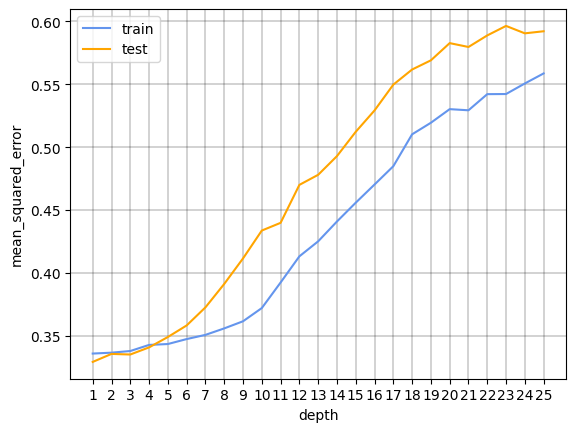

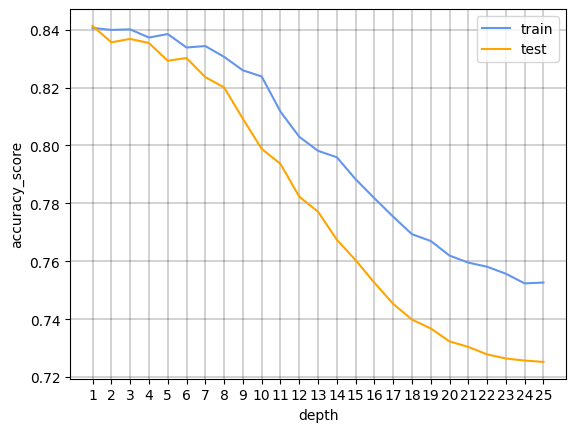

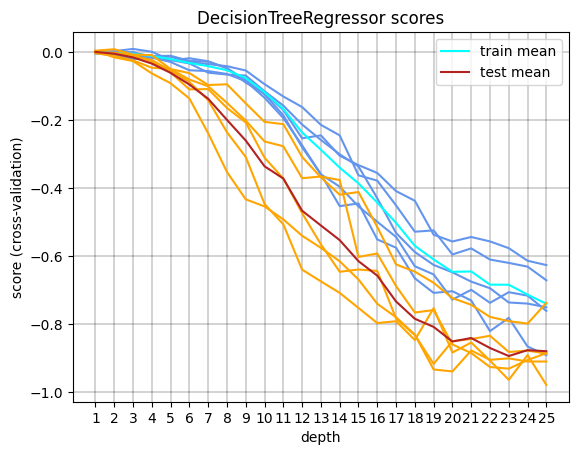

In [204]:
benchmark_decision_tree_regressor_result = benchmark_decision_tree(
  DecisionTreeRegressor,
  [athletes_tokyo_train_x, athletes_tokyo_train_y],
  [athletes_tokyo_test_x, athletes_tokyo_test_y],
  [mean_squared_error, accuracy_score],
  25,
  logging=False
)

##### Arbres décisionnels de classification

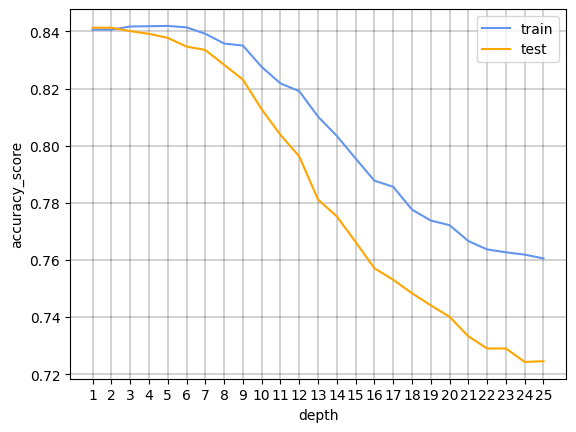

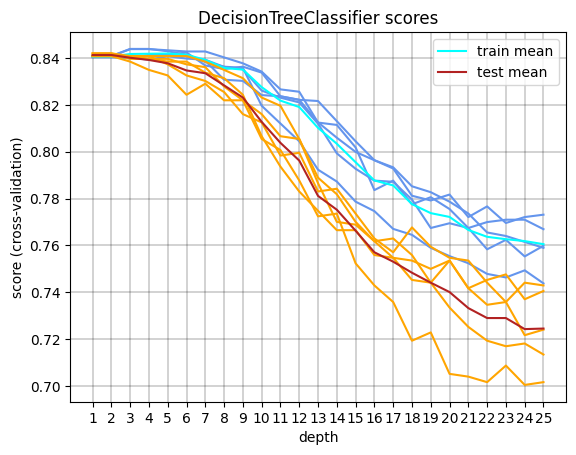

In [205]:
benchmark_decision_tree_classifier_result = benchmark_decision_tree(
  DecisionTreeClassifier,
  [athletes_tokyo_train_x, athletes_tokyo_train_y],
  [athletes_tokyo_test_x, athletes_tokyo_test_y],
  [accuracy_score],
  25,
  logging=False
)

##### Comparaison

Le modèle le plus intéressant est donc l'arbre décisionnel de classification de profondeur `6` en raison de son score moyen par cross-validation et son score de précision et du faible écart de ces scores en train et en test à cette profondeur.

On constate aussi comme attendu que les modèles quantitatifs (arbres décisionnels régressifs) ne sont pas les plus pertinents.

In [206]:
best_athletes_decision_tree = benchmark_decision_tree_classifier_result[6 -1]

#### Régressions

##### Régression linéaire

In [207]:
def benchmark_linear_regression(
  train_xy,
  test_xy,
  metrics,
  metrics_ranges,
  plot=True,
  logging=True,
  random_state=42,
  cv=None
):
  if cv is None:
    cv = StratifiedKFold(shuffle=True, random_state=random_state)

  (train_x, train_y) = train_xy
  (test_x, test_y) = test_xy

  models_metrics_results_train = []
  models_metrics_results_test = []

  model = LinearRegression()

  train_predictions = normalize_predictions(cross_val_predict(model, train_x, train_y, cv=cv))
  test_predictions = normalize_predictions(cross_val_predict(model, test_x, test_y, cv=cv))

  for i in range(len(metrics)):
    metric = metrics[i]

    models_metrics_results_train.append(metric(train_y, train_predictions))
    models_metrics_results_test.append(metric(test_y, test_predictions))

  model_scores_train = cross_val_score(model, train_x, train_y, cv=cv)
  model_scores_test = cross_val_score(model, test_x, test_y, cv=cv)

  if logging:
    for i in range(len(metrics)):
      metric = metrics[i]

      print(f'model {metric.__name__} metric train result:', models_metrics_results_train[i])
      print(f'model {metric.__name__} metric test result:', models_metrics_results_test[i])

    print('model train score (cross-validation):', model_scores_train)
    print('model test score (cross-validation):', model_scores_test)

    print()

  model_result = {
    'metrics_results': {
      'train': models_metrics_results_train,
      'test': models_metrics_results_test
    },
    'model': model,
    'train_xy': train_xy,
    'test_xy': test_xy,
    'scores': {
      'train': model_scores_train,
      'test': model_scores_test
    },
    'predictions': {
      'train': train_predictions,
      'test': test_predictions
    },
    'cv': cv
  }

  if plot:
    def draw_result_chart(results, xlabel, ylabel):
      for result in results:
        plt.plot([result[3]], [result[4]], 'o', color=result[2], label=result[1])

      abscisses = [v[0] for v in results if v[0] is not None]
      plt.xticks(np.arange(len(abscisses)), abscisses)

      plt.xlabel(xlabel)
      plt.ylabel(ylabel)

      for result in results:
        if result[1] is not None:
          plt.legend()
          break

      plt.grid(color='black', linestyle='-', linewidth=0.25)

      plt.show()

    for i in range(len(metrics)):
      metric = metrics[i]
      metric_range = metrics_ranges[i]

      plt.ylim(metric_range[0], metric_range[1])
      draw_result_chart(
        [
          ('train', None, 'cornflowerblue', 0, models_metrics_results_train[i]),
          ('test', None, 'orange', 1, models_metrics_results_test[i])
        ],
        '',
        metric.__name__
      )

    plt.title(f'{LinearRegression.__name__} scores')
    plt.ylim(0, 1)
    draw_result_chart(
      [
        ('train', None, 'cornflowerblue', 0, model_scores_train),
        (None, 'train mean', 'aqua', 0.025, np.array(model_scores_train).mean()),
        ('test', None, 'orange', 1, model_scores_test),
        (None, 'test mean', 'firebrick', 1.025, np.array(model_scores_test).mean())
      ],
      '',
      'score (cross-validation)'
    )

  return model_result

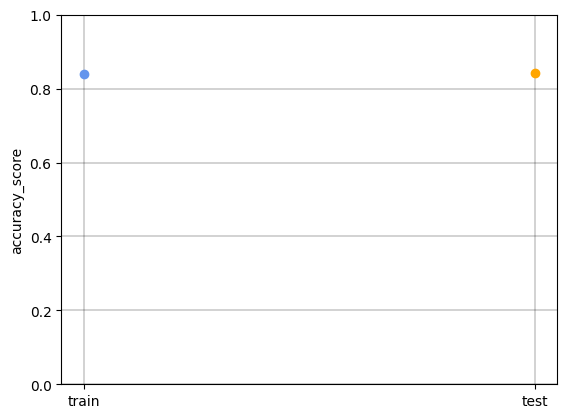

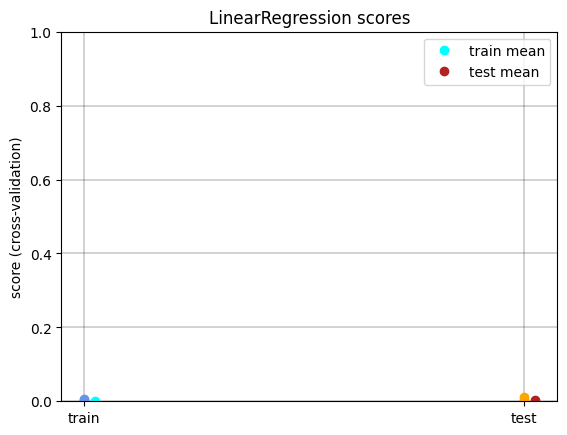

scores: {'train': array([ 0.00155325, -0.00122005,  0.0053892 , -0.0012293 ,  0.0031048 ]), 'test': array([0.0002125 , 0.0040324 , 0.01163562, 0.00179797, 0.00178794])}
train score mean: 0.001519580239053564
test score mean: 0.003893285109235567


In [208]:
benchmark_linear_regression_result = benchmark_linear_regression(
  [athletes_tokyo_train_x, athletes_tokyo_train_y],
  [athletes_tokyo_test_x, athletes_tokyo_test_y],
  [accuracy_score],
  [(0,1)],
  25,
  logging=False
)

linear_regression_scores = benchmark_linear_regression_result['scores']
print('scores:', linear_regression_scores)
print('train score mean:', linear_regression_scores['train'].mean())
print('test score mean:', linear_regression_scores['test'].mean())

##### Régression logistique

In [209]:
def benchmark_logistic_regression(
  train_xy,
  test_xy,
  metrics,
  metrics_ranges,
  plot=True,
  logging=True,
  random_state=42,
  cv=None
):
  if cv is None:
    cv = StratifiedKFold(shuffle=True, random_state=random_state)

  (train_x, train_y) = train_xy
  (test_x, test_y) = test_xy

  models_metrics_results_train = []
  models_metrics_results_test = []

  model = LogisticRegression(random_state=random_state)

  train_predictions = normalize_predictions(cross_val_predict(model, train_x, train_y, cv=cv))
  test_predictions = normalize_predictions(cross_val_predict(model, test_x, test_y, cv=cv))

  for i in range(len(metrics)):
    metric = metrics[i]

    models_metrics_results_train.append(metric(train_y, train_predictions))
    models_metrics_results_test.append(metric(test_y, test_predictions))

  model_scores_train = cross_val_score(model, train_x, train_y, cv=cv)
  model_scores_test = cross_val_score(model, test_x, test_y, cv=cv)

  if logging:
    for i in range(len(metrics)):
      metric = metrics[i]

      print(f'model {metric.__name__} metric train result:', models_metrics_results_train[i])
      print(f'model {metric.__name__} metric test result:', models_metrics_results_test[i])

    print('model train score (cross-validation):', model_scores_train)
    print('model test score (cross-validation):', model_scores_test)

    print()

  model_result = {
    'metrics_results': {
      'train': models_metrics_results_train,
      'test': models_metrics_results_test
    },
    'model': model,
    'train_xy': train_xy,
    'test_xy': test_xy,
    'scores': {
      'train': model_scores_train,
      'test': model_scores_test
    },
    'predictions': {
      'train': train_predictions,
      'test': test_predictions
    },
    'cv': cv
  }

  if plot:
    def draw_result_chart(results, xlabel, ylabel):
      for result in results:
        plt.plot([result[3]], [result[4]], 'o', color=result[2], label=result[1])

      abscisses = [v[0] for v in results if v[0] is not None]
      plt.xticks(np.arange(len(abscisses)), abscisses)

      plt.xlabel(xlabel)
      plt.ylabel(ylabel)

      for result in results:
        if result[1] is not None:
          plt.legend()
          break

      plt.grid(color='black', linestyle='-', linewidth=0.25)

      plt.show()

    for i in range(len(metrics)):
      metric = metrics[i]
      metric_range = metrics_ranges[i]

      plt.ylim(metric_range[0], metric_range[1])
      draw_result_chart(
        [
          ('train', None, 'cornflowerblue', 0, models_metrics_results_train[i]),
          ('test', None, 'orange', 1, models_metrics_results_test[i])
        ],
        '',
        metric.__name__
      )

    plt.title(f'{LogisticRegression.__name__} scores')
    plt.ylim(0, 1)
    draw_result_chart(
      [
        ('train', None, 'cornflowerblue', 0, model_scores_train),
        (None, 'train mean', 'aqua', 0.025, np.array(model_scores_train).mean()),
        ('test', None, 'orange', 1, model_scores_test),
        (None, 'test mean', 'firebrick', 1.025, np.array(model_scores_test).mean())
      ],
      '',
      'score (cross-validation)'
    )

  return model_result

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

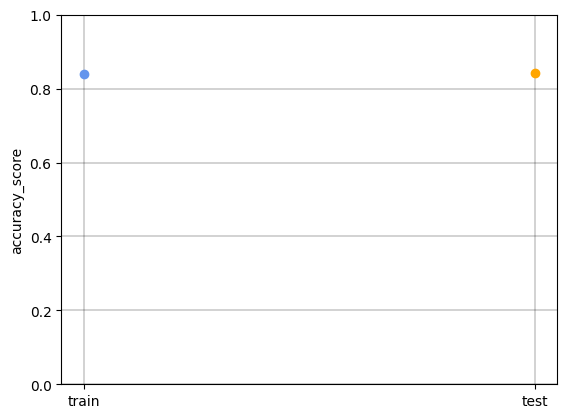

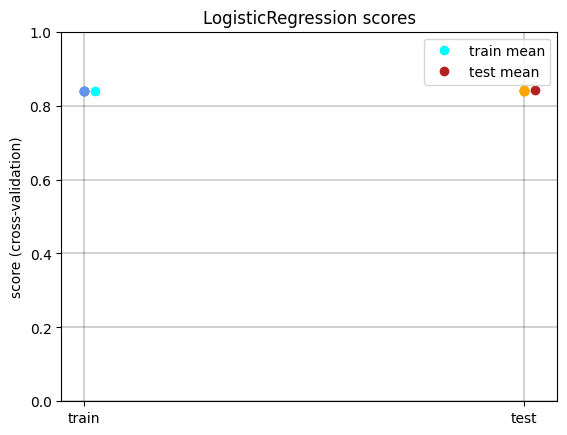

scores: {'train': array([0.8408287 , 0.8403234 , 0.8403234 , 0.84074823, 0.84074823]), 'test': array([0.84198113, 0.84198113, 0.84080189, 0.84080189, 0.84080189])}
train score mean: 0.8405943907489715
test score mean: 0.8412735849056604


In [210]:
benchmark_logistic_regression_result = benchmark_logistic_regression(
  [athletes_tokyo_train_x, athletes_tokyo_train_y],
  [athletes_tokyo_test_x, athletes_tokyo_test_y],
  [accuracy_score],
  [(0,1)],
  25,
  logging=False
)

logistic_regression_scores = benchmark_logistic_regression_result['scores']
print('scores:', logistic_regression_scores)
print('train score mean:', logistic_regression_scores['train'].mean())
print('test score mean:', logistic_regression_scores['test'].mean())

##### Comparaison

De même que pour les arbres décisionnels, le modèle qualitatif est plus pertinent.

In [211]:
best_athletes_regression = benchmark_logistic_regression_result

#### Arbre vs régression

In [212]:
print(best_athletes_decision_tree['scores']['train'].mean())
print(best_athletes_decision_tree['scores']['test'].mean())

0.8414029820700776
0.8346698113207547


In [213]:
print(best_athletes_regression['scores']['train'].mean())
print(best_athletes_regression['scores']['test'].mean())

0.8405943907489715
0.8412735849056604


In [214]:
print(round(best_athletes_regression['scores']['train'].mean() - best_athletes_decision_tree['scores']['train'].mean(), 2))
print(round(best_athletes_regression['scores']['test'].mean() - best_athletes_decision_tree['scores']['test'].mean(), 2))

-0.0
0.01


On peut donc considérer les deux modèles comme ayant des performances quasi-équivalentes.
On utilisera par la suite le modèle d'arbre décisionnel de classification.

In [215]:
best_athletes_estimator = best_athletes_decision_tree

#### Prédictions sur les JO de Paris

In [216]:
def reformat_numerized_athlete_event_results(numerized_athlete_event_results, qualitative_data_dict):
  athlete_event_results = numerized_athlete_event_results.copy()

  for qualitative_data_column in qualitative_data_dict.keys():
    qualitative_data_values = qualitative_data_dict[qualitative_data_column]
    num2qualitative = {}

    for i in range(len(qualitative_data_values)):
      num2qualitative[i] = qualitative_data_values[i]

    athlete_event_results[qualitative_data_column] = athlete_event_results[qualitative_data_column].replace(to_replace=num2qualitative)

  return athlete_event_results

In [217]:
def get_country_results(athlete_event_results):
  medal_types = ['bronze', 'silver', 'gold']
  country_codes = pd.unique(athlete_event_results['country_code'])

  country_results_data = {
    'country_code': [],
    'country_name': [],
    'rank': [],
    'gold_medal_count': [],
    'silver_medal_count': [],
    'bronze_medal_count': []
  }

  for country_code in country_codes:
    country_results_data['country_code'].append(country_code)
    country_results_data['country_name'].append(pd.unique(athlete_event_results[athlete_event_results['country_code'] == country_code]['country_name'])[0])
    country_results_data['rank'].append(0)

    country_athlete_event_results = athlete_event_results[athlete_event_results['country_code'] == country_code]
    #print(country_athlete_event_results[['country_code', 'athlete_medal']])

    for medal_type in medal_types:
      country_results_data[f'{medal_type}_medal_count'].append(len(country_athlete_event_results[country_athlete_event_results['athlete_medal'] == medal_type]))

  country_results = pd.DataFrame(data=country_results_data)

  medal_type_count_columns = ['gold_medal_count', 'silver_medal_count', 'bronze_medal_count']
  country_results.sort_values(medal_type_count_columns, ascending=[False for x in medal_type_count_columns], inplace=True)
  country_results.set_index('country_code', inplace=True)

  rank = 0
  for index, row in country_results.iterrows():
    country_results.loc[index, 'rank'] = rank+1
    rank += 1

  return country_results

In [218]:
def get_medal_type_totals(country_results):
  medal_type_count_columns = ['gold_medal_count', 'silver_medal_count', 'bronze_medal_count']
  medal_concentrations = np.array([])

  for medal_type_count_column in medal_type_count_columns:
    medal_concentrations = np.append(medal_concentrations, country_results[medal_type_count_column].sum())

  return medal_concentrations

On peut maintenant essayer de prédire les résultats pour les JO de Paris.

In [219]:
model = best_athletes_estimator['model']
#model = benchmark_decision_tree_classifier_result[3 -1]['model']
#model = best_athletes_regression['model']

model.fit(athletes_tokyo_x, athletes_tokyo_y)

DecisionTreeClassifier(max_depth=6, random_state=42)

In [220]:
numerized_athlete_event_results_paris_predicted = numerized_athlete_event_results_paris.copy()
numerized_athlete_event_results_paris_predicted['athlete_medal'] = model.predict(athletes_paris_x)

athletes_paris_predictions_accuracy = accuracy_score(athletes_paris_y, numerized_athlete_event_results_paris_predicted['athlete_medal'])
print(athletes_paris_predictions_accuracy)

0.8398633715089411


On constate qu'on arrive a prédire avec environ `84%` de précision la performance des athlètes à chaque événement d'une discipline donné.

En sommant par pays les résultats des athlètes pour chaque type de médaille, on devrait alors obtenir une prédiction du classement des pays (on affichera au moins le top 10):

In [221]:
qualitative_data_dict = {}

for qualitative_data_column in qualitative_data_columns:
  qualitative_data_dict[qualitative_data_column] = sorted(pd.unique(athlete_event_results_paris[qualitative_data_column]))

In [222]:
athlete_event_results_paris_predicted = reformat_numerized_athlete_event_results(numerized_athlete_event_results_paris_predicted, qualitative_data_dict)
contry_results_paris_predicted = get_country_results(athlete_event_results_paris_predicted)
contry_results_paris_predicted.iloc[:10]

,country_name,rank,gold_medal_count,silver_medal_count,bronze_medal_count
country_code,,,,,
JPN,Japan,1,0,12,2
FRA,France,2,0,9,2
USA,United States,3,0,9,2
GER,Germany,4,0,8,4
AUS,Australia,5,0,8,4
ESP,Spain,6,0,8,2
PUR,Puerto Rico,7,0,8,1
SSD,South Sudan,8,0,7,2
BRA,Brazil,9,0,7,1


In [223]:
medal_type_totals = get_medal_type_totals(contry_results_paris_predicted)
print(medal_type_totals)
print(medal_type_totals / medal_type_totals.sum())

[ 0. 99. 39.]
[0.        0.7173913 0.2826087]


In [224]:
country_results_paris = get_country_results(athlete_event_results_paris)
country_results_paris.iloc[:10]

,country_name,rank,gold_medal_count,silver_medal_count,bronze_medal_count
country_code,,,,,
USA,United States,1,134,101,95
CHN,China,2,71,57,40
NED,Netherlands,3,67,25,26
FRA,France,4,53,95,39
GBR,Great Britain,5,40,42,80
ESP,Spain,6,40,7,36
AUS,Australia,7,33,45,45
ITA,Italy,8,31,29,28
JPN,Japan,9,27,31,24


In [225]:
medal_type_totals = get_medal_type_totals(country_results_paris)
print('medal type totals:', medal_type_totals)
print('medal type repartitions:', medal_type_totals / medal_type_totals.sum())

medal type totals: [751. 748. 802.]
medal type repartitions: [0.32637983 0.32507605 0.34854411]


On constate que le classement prédit n'est pas très proche de la réalité. Pour essayer de comprendre pourquoi, on peut regarder ce qu'il en est pour les JO de Tokyo:

In [226]:
numerized_athlete_event_results_tokyo_predicted = numerized_athlete_event_results_tokyo.copy()
numerized_athlete_event_results_tokyo_predicted['athlete_medal'] = model.predict(athletes_tokyo_x)

athletes_tokyo_predictions_accuracy = accuracy_score(athletes_tokyo_y, numerized_athlete_event_results_tokyo_predicted['athlete_medal'])
print(athletes_tokyo_predictions_accuracy)

0.843416118304677


In [227]:
athlete_event_results_tokyo_predicted = reformat_numerized_athlete_event_results(numerized_athlete_event_results_tokyo_predicted, qualitative_data_dict)
country_results_tokyo_predicted = get_country_results(athlete_event_results_tokyo_predicted)
country_results_tokyo_predicted.iloc[:10]

,country_name,rank,gold_medal_count,silver_medal_count,bronze_medal_count
country_code,,,,,
JPN,Japan,1,23,0,0
USA,United States,2,3,9,0
POL,Poland,3,1,0,1
AUT,Austria,4,1,0,0
GBR,Great Britain,5,1,0,0
LTU,Lithuania,6,1,0,0
SWE,Sweden,7,1,0,0
MEX,Mexico,8,0,1,0
CHN,People's Republic of China,9,0,0,2


In [228]:
medal_type_totals = get_medal_type_totals(country_results_tokyo_predicted)
print('medal type totals:', medal_type_totals)
print('medal type repartitions:', medal_type_totals / medal_type_totals.sum())

medal type totals: [31. 10.  7.]
medal type repartitions: [0.64583333 0.20833333 0.14583333]


In [229]:
country_results_tokyo = get_country_results(athlete_event_results_tokyo)
country_results_tokyo.iloc[:10]

,country_name,rank,gold_medal_count,silver_medal_count,bronze_medal_count
country_code,,,,,
USA,United States,1,112,108,75
JPN,Japan,2,68,41,22
FRA,France,3,65,42,31
CHN,People's Republic of China,4,58,49,37
GBR,Great Britain,5,39,35,55
AUS,Australia,6,36,27,66
CAN,Canada,7,36,15,31
NED,Netherlands,8,33,21,17
NZL,New Zealand,9,29,28,8


In [230]:
medal_type_totals = get_medal_type_totals(country_results_tokyo)
print(medal_type_totals)
print(medal_type_totals / medal_type_totals.sum())

[742. 685. 823.]
[0.32977778 0.30444444 0.36577778]


On constate que le problème majeur est dans la prédiction des résultats autres que "pas de médaille". Notre modèle est évalué comme précis, mais cela est du au fait qu'il y a beaucoup plus d'athlètes qui n'ont pas de médaille que d'athlètes médaillés. Ainsi, notre modèle prédit un nombre bien trop faible de médailles.

# III - Mesure de l'impact de la non-participation de la Russie sur les résultats pour des sports spécifiques en 2024 ?

Essayons d'abord de mesurer cet impact statistiquement : le classement au sein de ces disciplines reste-t-il le même, seulement sans la Russie ? Si non, la différence de classements dans ces disciplines est-elle assez grande pour impacter le classement global des pays ?
Les disciplines évoquées ici sont celles dans lesquelles la Russie a un impact notable sur le classement, c'est-à-dire celles où les athètes russes sont performants. Déterminons les.

In [231]:
medals_tokyo = pd.read_csv(f'{DATA_ROOT}/DataTokyo/medals.csv')

In [232]:
import matplotlib.pyplot as plt
medals_df = pd.DataFrame(data = medals_tokyo)
medals_df.head()

,medal_type,medal_code,medal_date,athlete_short_name,athlete_name,athlete_sex,athlete_link,country_code,discipline_code,event,country,discipline
0,Gold Medal,1,2021-07-24 00:00:00.0,KIM JD,KIM Je Deok,X,../../../en/results/archery/athlete-profile-n1...,KOR,ARC,Mixed Team,Republic of Korea,Archery
1,Gold Medal,1,2021-07-24 00:00:00.0,AN S,AN San,X,../../../en/results/archery/athlete-profile-n1...,KOR,ARC,Mixed Team,Republic of Korea,Archery
2,Silver Medal,2,2021-07-24 00:00:00.0,SCHLOESSER G,SCHLOESSER Gabriela,X,../../../en/results/archery/athlete-profile-n1...,NED,ARC,Mixed Team,Netherlands,Archery
3,Silver Medal,2,2021-07-24 00:00:00.0,WIJLER S,WIJLER Steve,X,../../../en/results/archery/athlete-profile-n1...,NED,ARC,Mixed Team,Netherlands,Archery
4,Bronze Medal,3,2021-07-24 00:00:00.0,ALVAREZ L,ALVAREZ Luis,X,../../../en/results/archery/athlete-profile-n1...,MEX,ARC,Mixed Team,Mexico,Archery


In [233]:
all_medals_ROC = medals_df[medals_df['country_code'] == 'ROC']
all_medals_ROC.head()

,medal_type,medal_code,medal_date,athlete_short_name,athlete_name,athlete_sex,athlete_link,country_code,discipline_code,event,country,discipline
27,Silver Medal,2,2021-07-24 00:00:00.0,GALASHINA A,GALASHINA Anastasiia,W,../../../en/results/shooting/athlete-profile-n...,ROC,SHO,10m Air Rifle Women,ROC,Shooting
31,Bronze Medal,3,2021-07-24 00:00:00.0,ARTAMONOV M,ARTAMONOV Mikhail,M,../../../en/results/taekwondo/athlete-profile-...,ROC,TKW,Men -58kg,ROC,Taekwondo
43,Silver Medal,2,2021-07-25 00:00:00.0,OSIPOVA E,OSIPOVA Elena,W,../../../en/results/archery/athlete-profile-n1...,ROC,ARC,Women's Team,ROC,Archery
44,Silver Medal,2,2021-07-25 00:00:00.0,PEROVA K,PEROVA Ksenia,W,../../../en/results/archery/athlete-profile-n1...,ROC,ARC,Women's Team,ROC,Archery
45,Silver Medal,2,2021-07-25 00:00:00.0,GOMBOEVA S,GOMBOEVA Svetlana,W,../../../en/results/archery/athlete-profile-n1...,ROC,ARC,Women's Team,ROC,Archery


On a maintenant dans all_medals_ROC toutes les médailles des athlètes russes. On doit donc "rassembler" les médailles des évènements collectifs. Pour cela on se débarasse des informations sur les athlètes, dont on n'a pas besoin, et on supprime les lignes répétées.


In [234]:
medals_ROC = all_medals_ROC[['medal_type','medal_code','discipline_code','event','discipline']]
print(medals_ROC.duplicated().sum())

medals_ROC.drop_duplicates(inplace=True)
medals_ROC

76


<ipython-input-234-1bbdd82c4506>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medals_ROC.drop_duplicates(inplace=True)


,medal_type,medal_code,discipline_code,event,discipline
27,Silver Medal,2,SHO,10m Air Rifle Women,Shooting
31,Bronze Medal,3,TKW,Men -58kg,Taekwondo
43,Silver Medal,2,ARC,Women's Team,Archery
62,Silver Medal,2,FEN,Women's Foil Individual,Fencing
63,Bronze Medal,3,FEN,Women's Foil Individual,Fencing
...,...,...,...,...,...
2134,Silver Medal,2,VVO,Men,Volleyball
2199,Bronze Medal,3,WRE,Men's Freestyle 65kg,Wrestling
2201,Gold Medal,1,WRE,Men's Freestyle 97kg,Wrestling
2281,Silver Medal,2,HBL,Women,Handball


Text(0.5, 1.0, 'Medal Score of ROC by Discipline')

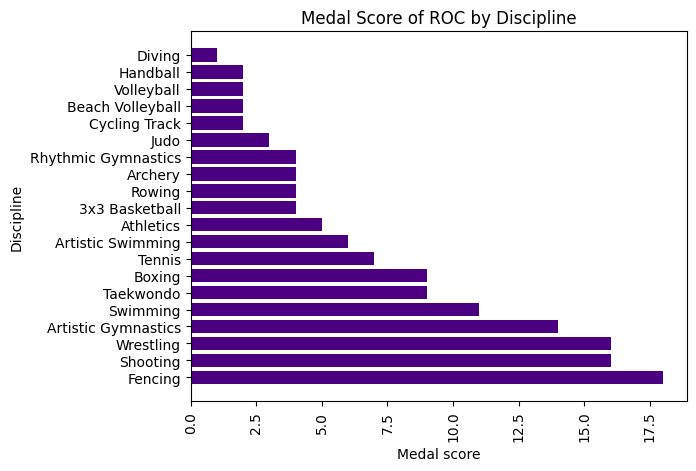

In [235]:
disciplines_ROC = medals_ROC['discipline'].unique()

data = []
for discipline in disciplines_ROC:
  medal_codes = medals_ROC[medals_ROC['discipline'] == discipline]['medal_code']
  medal_scores = 4 - medal_codes
  data.append([discipline, medal_scores.sum()])

df = pd.DataFrame(data, columns=['discipline', 'medal_score'])
df.sort_values('medal_score', ascending=False, inplace=True)

df.set_index('discipline', inplace=True)

plt.barh(df.index,df['medal_score'],color='indigo')
plt.xticks(rotation=90)
plt.xlabel('Medal score')
plt.ylabel('Discipline')
plt.title('Medal Score of ROC by Discipline')

Les sports dans lesquelles les athlètes russes ont le plus d'impact sur le classement global sont donc l'escrime, le tir, la lutte etc... Pour répondre à la question posée, on choisira de comparer le classement dans les 5 premières disciplines avec et sans participation de la Russie.

In [236]:
# On veut un dataframe contenant pour chaque discipline, chaque pays, le total des médailles de chaque type.
disciplines_perf = df.iloc[:5].index.to_list()
medals_paris = pd.read_csv(f'{DATA_ROOT}/DataParis/medals.csv')

medals_tokyo_grouped = (medals_tokyo[medals_tokyo['discipline'].isin(disciplines_perf)]
                        .drop_duplicates(subset=['country', 'medal_code', 'discipline', 'event'])
                        .groupby(['country', 'discipline', 'medal_code'])
                        .size()
                        .unstack(fill_value=0)
                        .stack(level=-1)
                        .unstack(level=-1)
                        )
medals_tokyo_grouped.columns = ['gold_count', 'silver_count', 'bronze_count']
medals_tokyo_grouped.reset_index(inplace=True)


medals_paris_grouped = (medals_paris[medals_paris['discipline'].isin(disciplines_perf)]
                        .drop_duplicates(subset=['country_long','medal_code','discipline','event'])
                        .groupby(['country_long','medal_code','discipline'])
                        .size()
                        .astype(int)
                        .reset_index(name='count')
                        .pivot_table(index=['country_long','discipline'],columns='medal_code',values='count',aggfunc='sum',fill_value=0)
                        .rename(columns={1:'gold_count',2:'silver_count',3:'bronze_count'})
                        )
medals_paris_grouped.reset_index(inplace=True)
medals_paris_grouped.columns = ['country','discipline','gold_count', 'silver_count', 'bronze_count']

In [237]:
medals_tokyo_grouped_sorted = medals_tokyo_grouped.sort_values(
    by=['gold_count','silver_count','bronze_count'],
    ascending=False,
    axis=0
)

medals_paris_grouped_sorted = medals_paris_grouped.sort_values(
    by=['gold_count','silver_count','bronze_count'],
    ascending=False,
    axis=0
)

top_5_per_discipline_tokyo = medals_tokyo_grouped_sorted.groupby('discipline').head(5)
top_5_per_discipline_paris = medals_paris_grouped_sorted.groupby('discipline').head(5)
top_5_per_discipline_paris.reset_index(inplace=True)
top_5_per_discipline_tokyo.reset_index(inplace=True)

for discipline in disciplines_perf:
    print("\n" + discipline + " :",
          "\nTokyo :", top_5_per_discipline_tokyo[top_5_per_discipline_tokyo['discipline'] == discipline].set_index('country')[['gold_count','silver_count','bronze_count']],
          "\n\nParis :", top_5_per_discipline_paris[top_5_per_discipline_paris['discipline'] == discipline].set_index('country')[['gold_count','silver_count','bronze_count']])


Fencing : 
Tokyo :                    gold_count  silver_count  bronze_count
country                                                  
ROC                         3             4             1
France                      2             2             1
Republic of Korea           1             1             3
Hungary                     1             1             1
Estonia                     1             0             1 

Paris :                           gold_count  silver_count  bronze_count
country                                                         
Japan                              2             1             2
United States of America           2             1             1
Republic of Korea                  2             1             0
Hong Kong, China                   2             0             0
France                             1             4             2

Shooting : 
Tokyo :                             gold_count  silver_count  bronze_count
country              

On remarque que bien qu'il y ait des changements dans les classements, les résultats sont très variables : certains pays apparaissent ou disparaissent complètement du classement, on ne peut donc pas par exemple affirmer que la non-participation de la Russie a permis aux US de mieux se classer en gymnastique artistique en 2024. Il est donc difficile d'évaluer l'impact de la non-participation de la Russie seulement avec ces données.

Le nombre de médailles de la Russie dans ces disciplines ne la plaçant pas toujours en haut du classement, il reste quand même notable et peux influencer les classements. En effet, on a déjà pu remarqué que ces classements se jouent parfois à peu de médailles.

Essayons maintenant d'utiliser le modèle de prédiction vu auparavant. Pour répondre à notre question nous prévoierons les résultats des JO 2024 en supposant la participation des athlètes russes, afin de comparer aux résultats réels.

### Utilisation du modèle

Ici le pré-traitement est le même que vu précedemment.

In [238]:
# Chargement des données de Tokyo
athlete_event_results_tokyo = pd.read_csv(f'{DATA_ROOT}/data-supp-tokyo/athlete-event-results/preprocessed.global.2020.summer.csv')
# Chargement des données de Paris
athlete_event_results_paris = pd.read_csv(f'{DATA_ROOT}/data-supp-paris/athlete-event-results/preprocessed.global.2024.summer.csv')

#On récupère les données de la Russie
athlete_event_results_tokyo_ROC = athlete_event_results_tokyo[athlete_event_results_tokyo['country_code'] == 'ROC']

# Exclusion des pays ne participant pas aux deux JO
athlete_event_results_tokyo, athlete_event_results_paris = exclude_non_participating_countries(athlete_event_results_tokyo, athlete_event_results_paris)

#On rajoute la Russie
athlete_event_results_tokyo = pd.concat([athlete_event_results_tokyo, athlete_event_results_tokyo_ROC])
######

# Sélection des features d'entrainement
athletes_model_features = [
  'discipline',
  'athlete_age',
  'athlete_sex',
  'athlete_height_cm',
  'athlete_weight_kg'
]

# "Numérisation" des données qualitatives (ex: la discipline, le sexe)
numerized_athlete_event_results_tokyo = numerize_qualitative_data(athlete_event_results_tokyo, qualitative_data_columns)
numerized_athlete_event_results_paris = numerize_qualitative_data(athlete_event_results_paris, qualitative_data_columns)

# Création des jeux de donnés nécessaire à l'entrainement du modèle
athletes_tokyo_train, athletes_tokyo_test = train_test_split(numerized_athlete_event_results_tokyo, test_size=0.3, random_state=42)

athletes_tokyo_train_x = athletes_tokyo_train[athletes_model_features]
athletes_tokyo_train_y = athletes_tokyo_train['athlete_medal']

athletes_tokyo_test_x = athletes_tokyo_test[athletes_model_features]
athletes_tokyo_test_y = athletes_tokyo_test['athlete_medal']

# Séparation des résultats réels pour comparer les prédictions à la réalité
athletes_tokyo_x = numerized_athlete_event_results_tokyo[athletes_model_features]
athletes_tokyo_y = numerized_athlete_event_results_tokyo['athlete_medal']

athletes_paris_x = numerized_athlete_event_results_paris[athletes_model_features]
athletes_paris_y = numerized_athlete_event_results_paris['athlete_medal']

['AFG', 'ALB', 'ALG', 'ASA', 'AND', 'ANG', 'ANT', 'ARG', 'ARM', 'ARU', 'AUS', 'AUT', 'AZE', 'BRN', 'BAN', 'BAR', 'BEL', 'BIZ', 'BEN', 'BER', 'BHU', 'BOL', 'BIH', 'BOT', 'BRA', 'IVB', 'BRU', 'BUL', 'BUR', 'BDI', 'CPV', 'CAM', 'CMR', 'CAN', 'CAY', 'CAF', 'CHA', 'CHI', 'TPE', 'COL', 'COM', 'CGO', 'COK', 'CRC', 'CIV', 'CRO', 'CUB', 'CYP', 'CZE', 'COD', 'DEN', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'ESA', 'GEQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FSM', 'FIJ', 'FIN', 'FRA', 'GAB', 'GEO', 'GER', 'GHA', 'GBR', 'GRE', 'GRN', 'GUM', 'GUA', 'GUI', 'GBS', 'GUY', 'HAI', 'HON', 'HKG', 'HUN', 'ISL', 'IND', 'INA', 'IRQ', 'IRL', 'IRI', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KSA', 'KIR', 'KOS', 'KUW', 'KGZ', 'LAO', 'LAT', 'LBN', 'LES', 'LBR', 'LBA', 'LIE', 'LTU', 'LUX', 'MAD', 'MAW', 'MAS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTN', 'MRI', 'MEX', 'MON', 'MGL', 'MNE', 'MAR', 'MOZ', 'MYA', 'NAM', 'NRU', 'NEP', 'NED', 'NZL', 'NCA', 'NIG', 'NGR', 'MKD', 'NOR', 'OMA', 'PAK', 'PLW', 'PLE', 'PAN', 'PNG', 'PAR', 'CHN'

In [239]:
# Récupération du meilleur modèle
model = best_athletes_estimator['model']

# Entrainement du modèle
model.fit(
  X=numerized_athlete_event_results_tokyo[athletes_model_features],
  y=numerized_athlete_event_results_tokyo['athlete_medal']
)

######

# Prédiction des résultats pour paris
athletes_paris_predictions = model.predict(athletes_paris_x)

# Copie des vrais données de résultats de Paris
numerized_athlete_event_results_paris_predicted = numerized_athlete_event_results_paris.copy()

# Remplacement des vrais résultats copiés par les prédictions
numerized_athlete_event_results_paris_predicted['athlete_medal'] = athletes_paris_predictions

# Vérification de la précision des résultats
athletes_paris_predictions_accuracy = accuracy_score(
  y_true=athletes_paris_y,
  y_pred=numerized_athlete_event_results_paris_predicted['athlete_medal']
)
print(athletes_paris_predictions_accuracy)

######

# Reformatage des données "numérisées" en données qualitatives
qualitative_data_dict = {}
for qualitative_data_column in qualitative_data_columns:
  qualitative_data_dict[qualitative_data_column] = sorted(pd.unique(athlete_event_results_paris[qualitative_data_column]))

athlete_event_results_paris_predicted = reformat_numerized_athlete_event_results(numerized_athlete_event_results_paris_predicted, qualitative_data_dict)

######

# Sommation des résultats  prédits des athlètes par pays
contry_results_paris_predicted = get_country_results(athlete_event_results_paris_predicted)
# Récupération du top 10 prédit
print(contry_results_paris_predicted.iloc[:10])

# Sommation des résultats réels des athlètes par pays
contry_results_paris = get_country_results(athlete_event_results_paris)
# Récupération du top 10 prédit
print(contry_results_paris.iloc[:10])

0.8351751389726073
              country_name  rank  gold_medal_count  silver_medal_count  \
country_code                                                             
RSA           South Africa     1                10                   0   
GER                Germany     2                 7                   8   
NGR                Nigeria     3                 6                   1   
ITA                  Italy     4                 6                   0   
NED            Netherlands     5                 5                   0   
BRA                 Brazil     6                 4                   7   
BAH                Bahamas     7                 4                   0   
JPN                  Japan     8                 3                  12   
CHN                  China     9                 3                   5   
JAM                Jamaica    10                 3                   0   

              bronze_medal_count  
country_code                      
RSA                   

Comme dit précedemment, bien que les résultats du modèle soient plutôt précis (~80%), les classements globaux déduits de ces résultats ne le sont pas. Ici, on obtient un classement improbable, qui semble encore moins juste que lorqu'on excluait la Russie, on ne peut donc pas interpréter ces résultats pour répondre à la question.

# IV - Etude de la corrélation entre les variables socio-économiques et le succès aux JO 2024.

Nous allons maintenant étudier l'impact des variables socio-économiques sur le succès des pays aux JO 2024. Pour ce faire, nous avons utilisé un dataset externe contenant des variables telles que la densité de population, le taux de fertilité, le produit intérieur brut, le salaire minimum, etc.

Il faut tout d'abord relier les pays des datasets des JO à ceux du dataset utilisé, et nous devons changer quelques noms qui diffèrent. On notera également que certains pays participants comme Taipei ou le Kosovo ne sont pas présents dans le dataset utilisé.

In [251]:
medals_total_tokyo = pd.read_csv(f'{DATA_ROOT}/DataTokyo/medals_total.csv')
world_data = pd.read_csv(f'{DATA_ROOT}/world-data-2023.csv')

world_data['Country'] = world_data['Country'].replace({
    'United States': 'United States of America',
    'China': 'People\'s Republic of China',
    'United Kingdom': 'Great Britain',
    'Russia': 'ROC',
    'South Korea': 'Republic of Korea',
    'Iran': 'Islamic Republic of Iran',
    'Republic of Ireland': 'Ireland',
    'The Bahamas': 'Bahamas',
    'Ivory Coast': 'Côte d\'Ivoire',
    'Moldova': 'Republic of Moldova',
    'Syria': 'Syrian Arab Republic'
})

data_tokyo = pd.merge(medals_total_tokyo, world_data, on='Country')
medals_total_tokyo['Country'][~medals_total_tokyo['Country'].isin(data_tokyo['Country'])]

,Country
33,Chinese Taipei
42,Kosovo
48,"Hong Kong, China"
62,Bermuda
64,Puerto Rico


In [252]:
medals_total_paris = pd.read_csv(f'{DATA_ROOT}/DataParis/medals_total.csv').rename(columns={'country': 'Country'})
world_data = pd.read_csv(f'{DATA_ROOT}/world-data-2023.csv')

world_data['Country'] = world_data['Country'].replace({
    'United Kingdom': 'Great Britain',
    'South Korea': 'Korea',
    'Republic of Ireland': 'Ireland',
    'Iran': 'IR Iran',
    'Czech Republic': 'Czechia',
    'Turkey': 'Türkiye',
    'North Korea': 'DPR Korea',
    'Moldova': 'Republic of Moldova',
    'Cape Verde': 'Cabo Verde',
    'Ivory Coast': 'Côte d\'Ivoire'
})

data_paris = pd.merge(medals_total_paris, world_data, on='Country')
medals_total_paris['Country'][~medals_total_paris['Country'].isin(data_paris['Country'])]

,Country
34,Chinese Taipei
36,"Hong Kong, China"
46,AIN
73,Kosovo
83,Puerto Rico
86,EOR


In [253]:
pd.set_option('display.max_columns', None)
print(data_tokyo.columns)

Index(['Rank', 'Country Code', 'Gold Medal', 'Silver Medal', 'Bronze Medal',
       'Total', 'Country', 'Density\n(P/Km2)', 'Abbreviation',
       'Agricultural Land( %)', 'Land Area(Km2)', 'Armed Forces size',
       'Birth Rate', 'Calling Code', 'Capital/Major City', 'Co2-Emissions',
       'CPI', 'CPI Change (%)', 'Currency-Code', 'Fertility Rate',
       'Forested Area (%)', 'Gasoline Price', 'GDP',
       'Gross primary education enrollment (%)',
       'Gross tertiary education enrollment (%)', 'Infant mortality',
       'Largest city', 'Life expectancy', 'Maternal mortality ratio',
       'Minimum wage', 'Official language', 'Out of pocket health expenditure',
       'Physicians per thousand', 'Population',
       'Population: Labor force participation (%)', 'Tax revenue (%)',
       'Total tax rate', 'Unemployment rate', 'Urban_population', 'Latitude',
       'Longitude'],
      dtype='object')


Nous sélectionnons maintenant uniquement les colonnes numériques pour étudier les corrélations, et nous devons les formater sous forme de nombres car le dataset utilisé a un format non adéquat avec des symboles pourcents, des virgules et des symboles dollar.

In [254]:
features = ['Density\n(P/Km2)', 'Agricultural Land( %)', 'Land Area(Km2)', 'Armed Forces size', 'Birth Rate', 'Co2-Emissions', 'CPI', 'CPI Change (%)', 'Fertility Rate', 'Forested Area (%)', 'GDP', 'Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)', 'Infant mortality', 'Life expectancy', 'Maternal mortality ratio', 'Minimum wage', 'Out of pocket health expenditure', 'Physicians per thousand', 'Population', 'Population: Labor force participation (%)', 'Tax revenue (%)', 'Total tax rate', 'Unemployment rate', 'Urban_population']

def format_columns(x):
    if x.dtype == 'object':
        return x.str.replace(r'[,%$]', '', regex=True).astype(float)
    else:
        return x

X_tokyo = data_tokyo[features].apply(format_columns)
y_tokyo = data_tokyo['Total']

X_tokyo.describe()

,Density\n(P/Km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Fertility Rate,Forested Area (%),GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Life expectancy,Maternal mortality ratio,Minimum wage,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population
count,88.000000,87.000000,8.800000e+01,8.500000e+01,87.000000,8.600000e+01,83.000000,84.000000,87.000000,87.000000,8.800000e+01,87.000000,87.000000,87.000000,87.000000,86.000000,72.000000,87.000000,87.000000,8.800000e+01,85.000000,83.000000,85.000000,85.000000,8.700000e+01
mean,151.500000,43.072414,1.151751e+06,2.327882e+05,15.749195,3.669526e+05,175.093012,7.321429,2.142989,27.886207,9.973988e+11,101.511494,54.598851,12.416092,75.381609,68.209302,3.027639,31.119540,2.698391,6.919408e+07,60.816471,17.077108,39.567059,6.879882,4.109582e+07
std,257.724302,21.026211,2.738214e+06,4.894343e+05,7.722112,1.216147e+06,291.518692,28.566334,0.903070,19.571789,3.146758e+12,7.798501,27.486350,13.499689,6.253400,139.760814,3.498646,17.484949,1.692129,2.096830e+08,8.268498,6.296734,15.028262,4.930860,1.080545e+08
min,2.000000,1.400000,6.100000e+01,1.000000e+03,6.400000,2.680000e+02,99.550000,-3.200000,0.980000,0.000000,1.228170e+09,81.400000,4.800000,1.400000,54.300000,2.000000,0.010000,5.300000,0.080000,3.386000e+04,39.300000,1.400000,9.900000,0.090000,3.296900e+04
25%,45.250000,27.900000,6.512225e+04,2.200000e+04,10.000000,2.514550e+04,113.690000,0.975000,1.560000,10.400000,4.299803e+10,99.400000,35.350000,3.350000,71.950000,7.000000,0.487500,16.050000,1.460000,5.262689e+06,55.900000,12.700000,29.500000,3.910000,3.520183e+06
50%,94.500000,44.600000,2.562240e+05,5.800000e+04,13.470000,5.977800e+04,121.460000,2.250000,1.760000,30.900000,1.951975e+11,101.200000,59.600000,6.700000,75.800000,19.000000,1.510000,28.300000,2.610000,1.158939e+07,61.400000,16.800000,38.100000,5.470000,9.213048e+06
75%,142.000000,58.600000,6.787412e+05,2.150000e+05,19.615000,2.480185e+05,155.505000,3.950000,2.415000,40.500000,5.340372e+11,104.850000,71.700000,15.750000,81.000000,55.750000,3.797500,41.000000,3.745000,5.068186e+07,65.500000,21.950000,47.800000,8.800000,3.661100e+07
max,2239.000000,80.800000,1.709824e+07,3.031000e+06,38.140000,9.893038e+06,2740.270000,254.900000,5.390000,73.100000,2.142770e+13,126.600000,136.600000,75.700000,85.400000,917.000000,13.590000,81.600000,8.420000,1.397715e+09,86.800000,32.400000,106.300000,28.180000,8.429340e+08


Nous remarquons qu'il y a quelques données manquantes dans le dataset, et pour les traîter nous utilisons une imputation KNN qui va permettre de remplacer les valeurs manquantes en utilisant celles des 5 plus proches voisins.

In [255]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
X_tokyo_imputed = pd.DataFrame(imputer.fit_transform(X_tokyo))
X_tokyo_imputed.columns = X_tokyo.columns
X_tokyo_imputed.describe()

,Density\n(P/Km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Fertility Rate,Forested Area (%),GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Life expectancy,Maternal mortality ratio,Minimum wage,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population
count,88.000000,88.000000,8.800000e+01,8.800000e+01,88.000000,8.800000e+01,88.000000,88.000000,88.000000,88.000000,8.800000e+01,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,8.800000e+01,88.000000,88.000000,88.000000,88.000000,8.800000e+01
mean,151.500000,43.120682,1.151751e+06,2.252886e+05,15.783409,3.587208e+05,172.955273,7.209318,2.144705,27.767727,9.973988e+11,101.486364,54.373182,12.454091,75.332500,68.256818,2.987591,31.168182,2.694659,6.919408e+07,60.747273,16.982273,39.443409,6.991886,4.064465e+07
std,257.724302,20.909925,2.738214e+06,4.825953e+05,7.684309,1.203313e+06,283.162446,27.914475,0.898009,19.490697,3.146758e+12,7.757135,27.409798,13.426613,6.234401,138.146522,3.216905,17.390158,1.682740,2.096830e+08,8.133203,6.149108,14.813617,4.887274,1.075151e+08
min,2.000000,1.400000,6.100000e+01,1.000000e+03,6.400000,2.680000e+02,99.550000,-3.200000,0.980000,0.000000,1.228170e+09,81.400000,4.800000,1.400000,54.300000,2.000000,0.010000,5.300000,0.080000,3.386000e+04,39.300000,1.400000,9.900000,0.090000,3.296900e+04
25%,45.250000,28.050000,6.512225e+04,2.100000e+04,10.000000,1.780450e+04,114.207500,1.000000,1.560000,10.700000,4.299803e+10,99.375000,35.085000,3.375000,71.800000,7.000000,0.630000,16.475000,1.485000,5.262689e+06,55.975000,12.950000,29.425000,3.955000,3.123027e+06
50%,94.500000,44.900000,2.562240e+05,5.050000e+04,13.695000,5.351100e+04,121.890000,2.300000,1.760000,30.900000,1.951975e+11,101.100000,57.450000,7.050000,75.750000,19.000000,1.570000,28.300000,2.610000,1.158939e+07,61.050000,15.420000,38.000000,5.535000,9.117106e+06
75%,142.000000,58.500000,6.787412e+05,2.007500e+05,19.562500,2.474775e+05,152.217500,4.200000,2.412500,40.450000,5.340372e+11,104.825000,71.350000,16.045000,81.000000,60.000000,4.053000,40.800000,3.712500,5.068186e+07,65.200000,21.750000,47.500000,9.091500,3.595280e+07
max,2239.000000,80.800000,1.709824e+07,3.031000e+06,38.140000,9.893038e+06,2740.270000,254.900000,5.390000,73.100000,2.142770e+13,126.600000,136.600000,75.700000,85.400000,917.000000,13.590000,81.600000,8.420000,1.397715e+09,86.800000,32.400000,106.300000,28.180000,8.429340e+08


Enfin, nous allons utiliser un modèle d'arbre de régression pour prédire le nombre total de médailles par pays en fonction des variables socio-économiques. Nous avons décidé d'utiliser ce type de modèle car il permettra facilement de voir les principaux splits qui indiquent les variables les plus influentes dans le choix du nombre de médailles, et il ne suppose pas beaucoup de préconditions sur la distribution des données.

In [256]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import mean_squared_error, r2_score

model_tree = DecisionTreeRegressor(max_depth=5, random_state=0)
model_tree.fit(X_tokyo_imputed, y_tokyo)

preds = model_tree.predict(X_tokyo_imputed)
mse = mean_squared_error(y_tokyo, preds)
r2 = r2_score(y_tokyo, preds)
print(mse)
print(r2)

8.759594053929389
0.9767593664635125


Ainsi, avec un score R2 de plus de 97%, nous obtenons l'arbre de regression suivant pour les données des JO Tokyo 2020 :

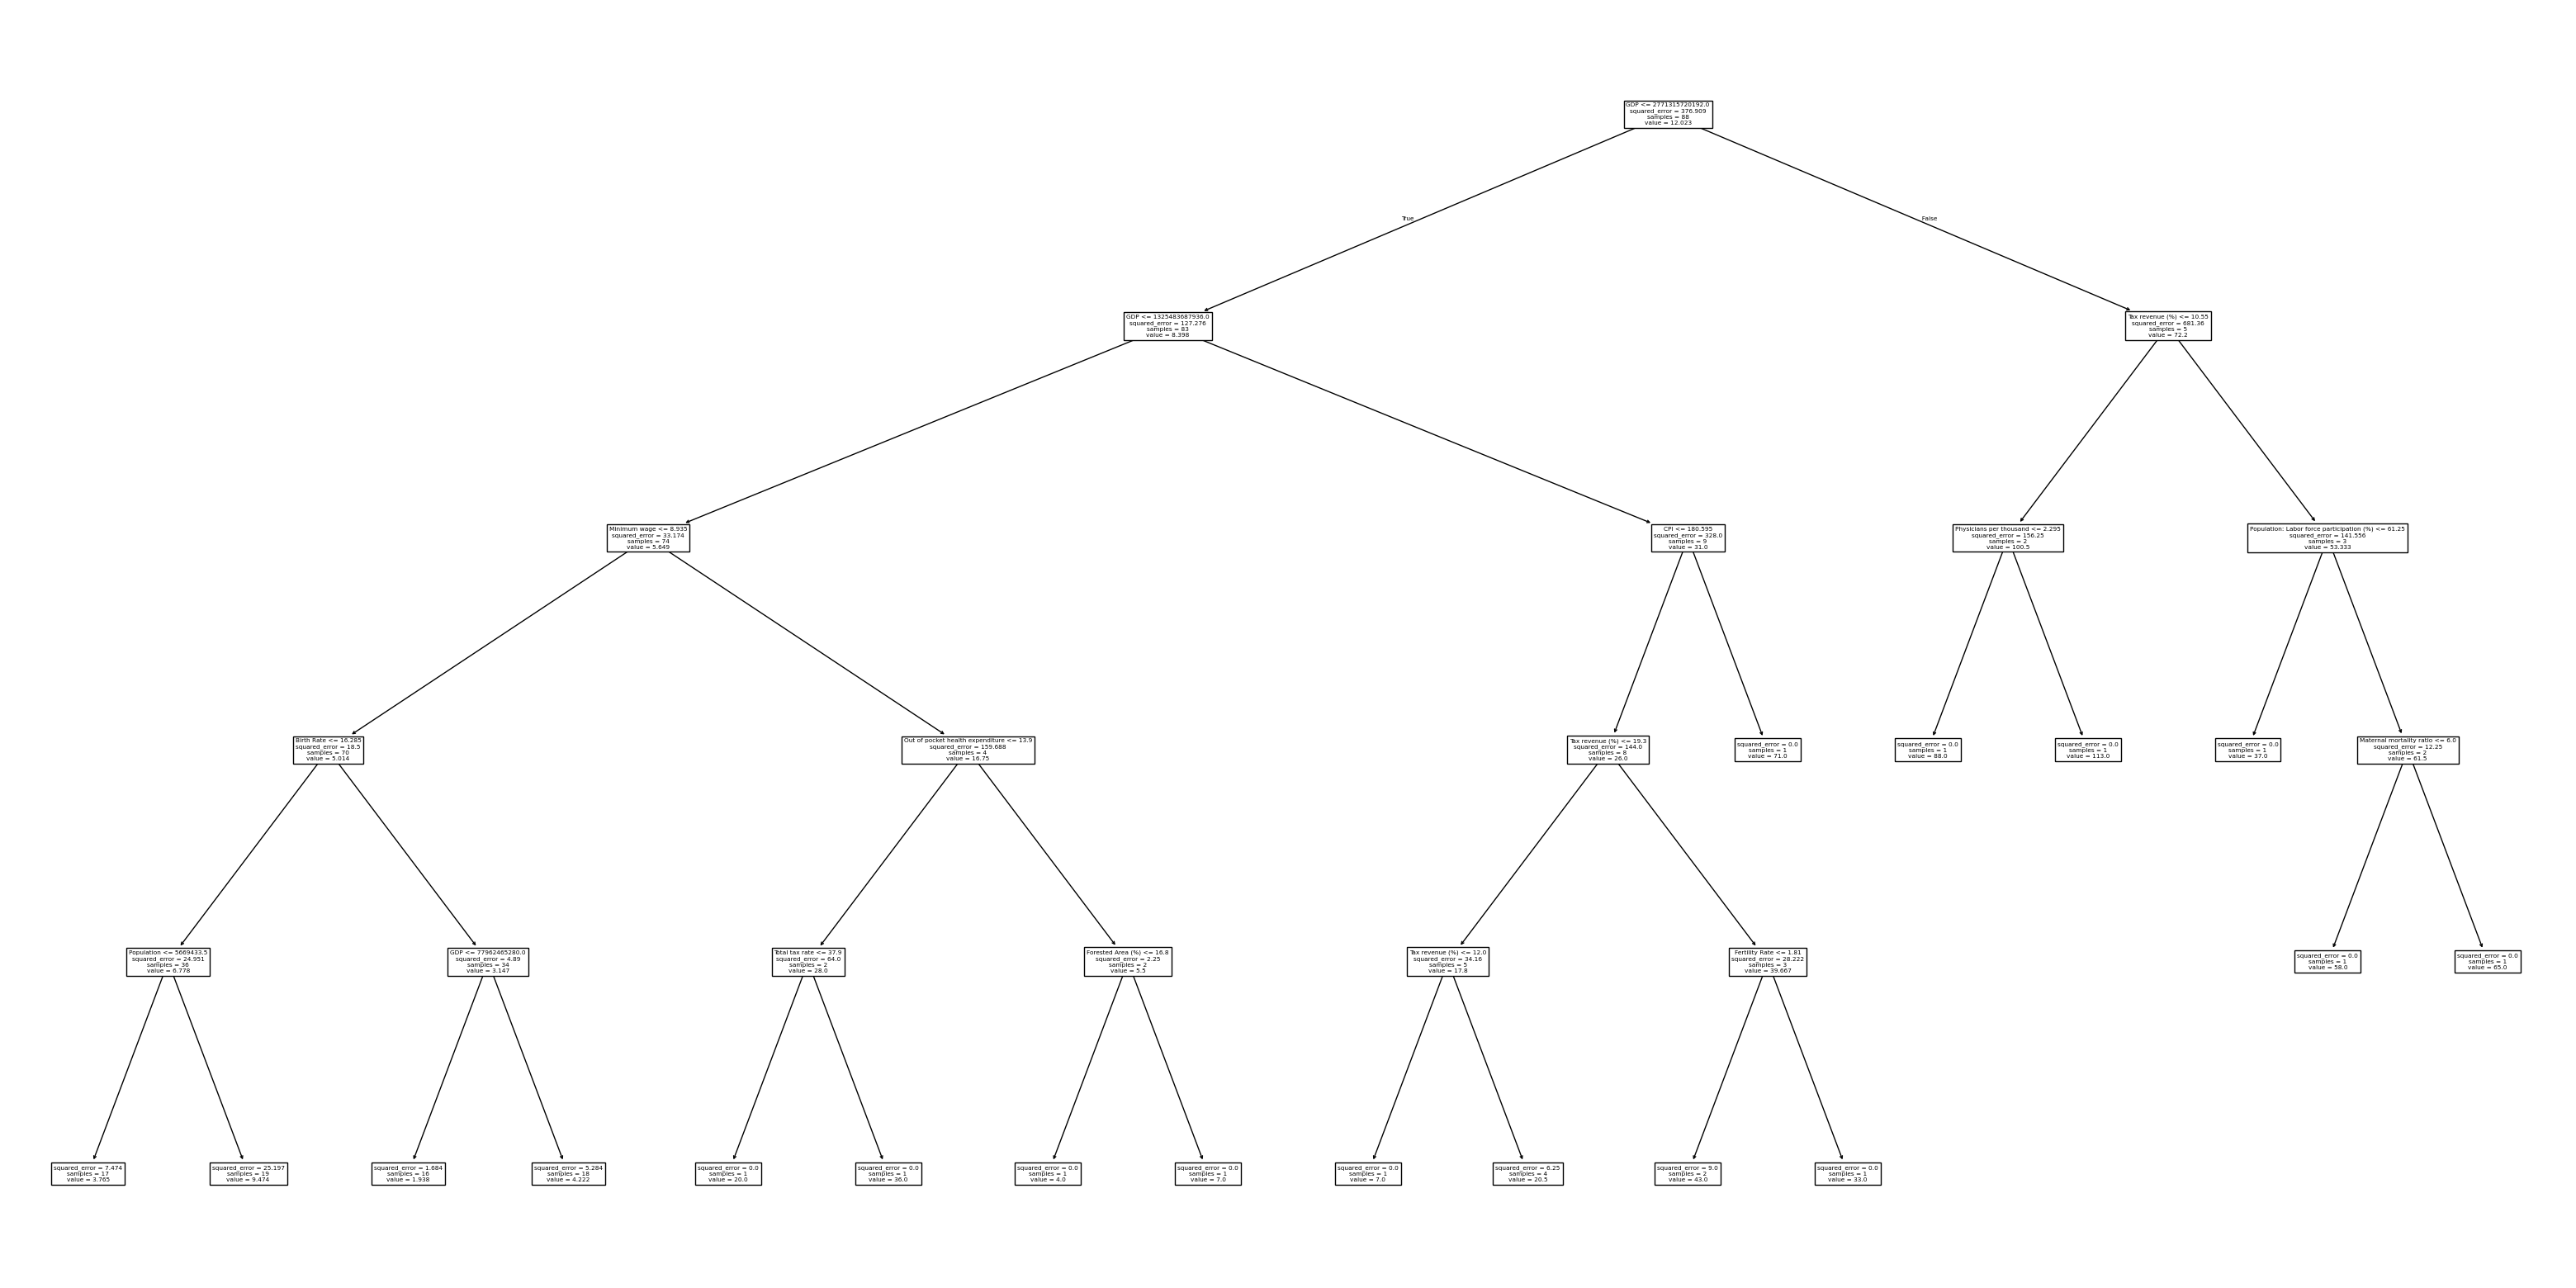

In [257]:
plt.figure(figsize=(40,20))
plot_tree(model_tree, feature_names=features)
plt.show()

In [258]:
print(export_text(model_tree, feature_names=features))

|--- GDP <= 2771315720192.00
|   |--- GDP <= 1325483687936.00
|   |   |--- Minimum wage <= 8.93
|   |   |   |--- Birth Rate <= 16.28
|   |   |   |   |--- Population <= 5669433.50
|   |   |   |   |   |--- value: [3.76]
|   |   |   |   |--- Population >  5669433.50
|   |   |   |   |   |--- value: [9.47]
|   |   |   |--- Birth Rate >  16.28
|   |   |   |   |--- GDP <= 77962465280.00
|   |   |   |   |   |--- value: [1.94]
|   |   |   |   |--- GDP >  77962465280.00
|   |   |   |   |   |--- value: [4.22]
|   |   |--- Minimum wage >  8.93
|   |   |   |--- Out of pocket health expenditure <= 13.90
|   |   |   |   |--- Total tax rate <= 37.90
|   |   |   |   |   |--- value: [20.00]
|   |   |   |   |--- Total tax rate >  37.90
|   |   |   |   |   |--- value: [36.00]
|   |   |   |--- Out of pocket health expenditure >  13.90
|   |   |   |   |--- Forested Area (%) <= 16.80
|   |   |   |   |   |--- value: [4.00]
|   |   |   |   |--- Forested Area (%) >  16.80
|   |   |   |   |   |--- value: [7.00]


Nous observons tout d'abord que les pays possédant un PIB inférieur à 2771 milliards de dollars obtiennent généralement un petit nombre de médailles, tandis que ceux avec un PIB supérieur obtiennent généralement un grand nombre de médailles aux JO 2020.

Ensuite, pour les pays avec un PIB supérieur à 2771 milliards de dollars, c'est le revenu des taxes, et pour les pays avec un PIB inférieur à 2771 milliards, il y a encore un split sur le PIB puis sur le salaire minimum ou sur l'indice des prix à la consommation.

In [259]:
X_paris = data_paris[features].apply(format_columns)
y_paris = data_paris['Total']

X_paris_imputed = pd.DataFrame(imputer.fit_transform(X_paris))
X_paris_imputed.columns = X_paris.columns

model_tree.fit(X_paris_imputed, y_paris)

preds = model_tree.predict(X_paris_imputed)
mse = mean_squared_error(y_paris, preds)
r2 = r2_score(y_paris, preds)
print(mse)
print(r2)

6.312733003430679
0.9842988809239909


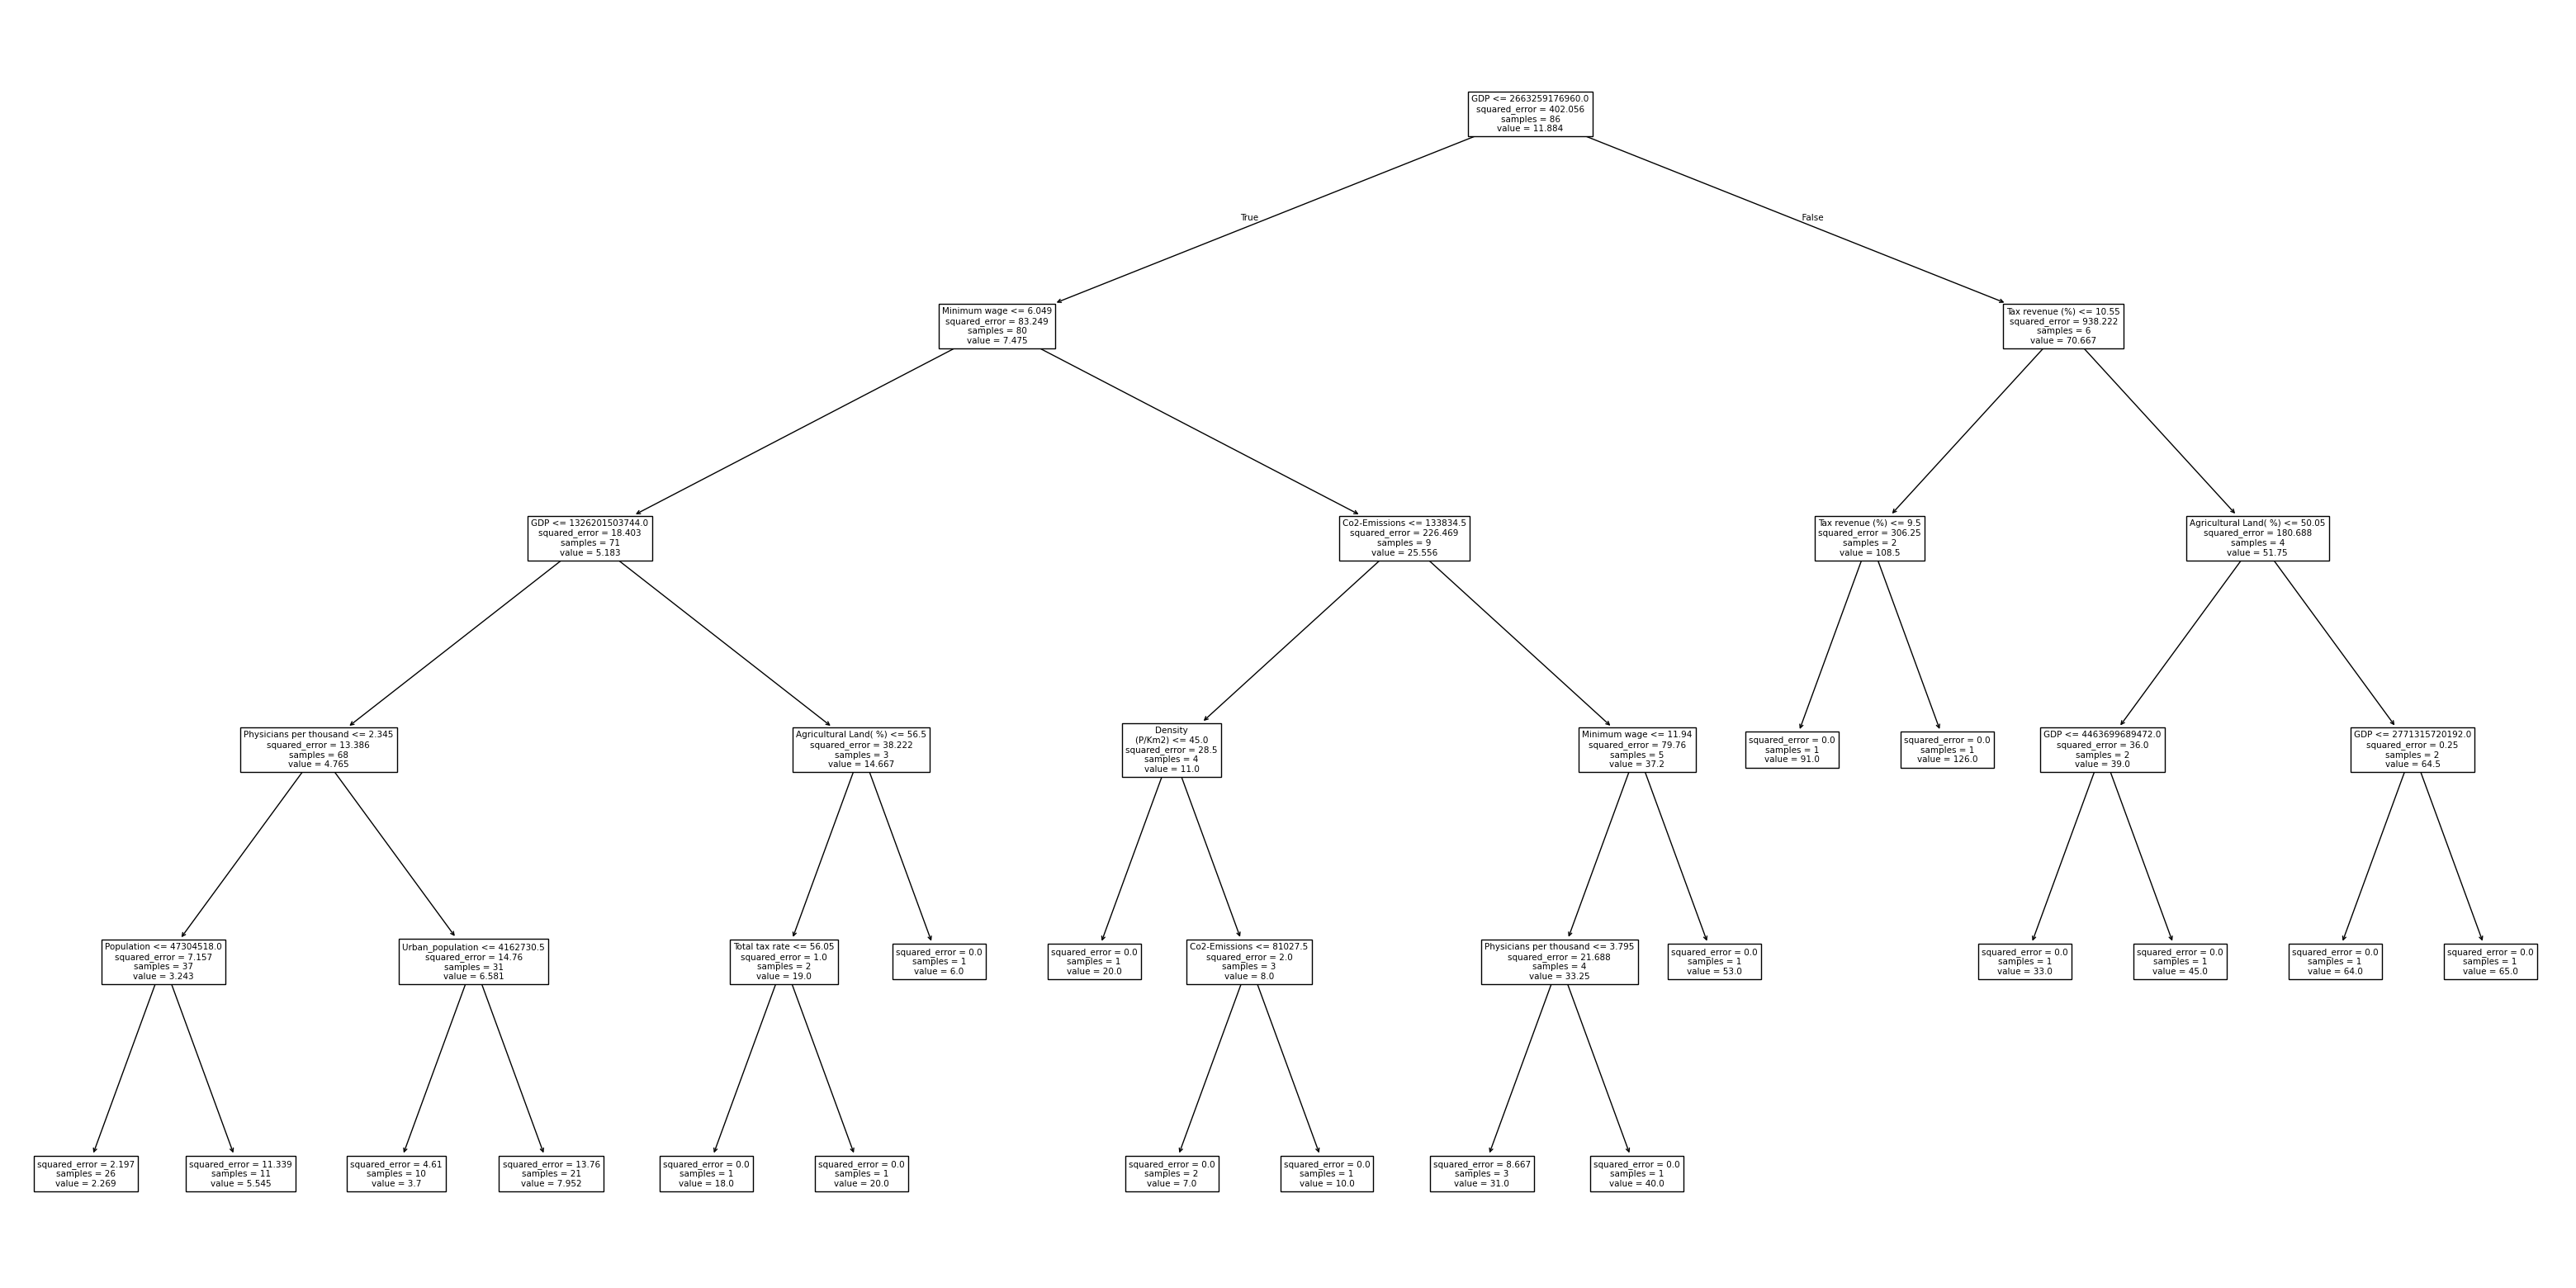

In [260]:
plt.figure(figsize=(40,20))
plot_tree(model_tree, feature_names=features)
plt.show()

In [261]:
print(export_text(model_tree, feature_names=features))

|--- GDP <= 2663259176960.00
|   |--- Minimum wage <= 6.05
|   |   |--- GDP <= 1326201503744.00
|   |   |   |--- Physicians per thousand <= 2.34
|   |   |   |   |--- Population <= 47304518.00
|   |   |   |   |   |--- value: [2.27]
|   |   |   |   |--- Population >  47304518.00
|   |   |   |   |   |--- value: [5.55]
|   |   |   |--- Physicians per thousand >  2.34
|   |   |   |   |--- Urban_population <= 4162730.50
|   |   |   |   |   |--- value: [3.70]
|   |   |   |   |--- Urban_population >  4162730.50
|   |   |   |   |   |--- value: [7.95]
|   |   |--- GDP >  1326201503744.00
|   |   |   |--- Agricultural Land( %) <= 56.50
|   |   |   |   |--- Total tax rate <= 56.05
|   |   |   |   |   |--- value: [18.00]
|   |   |   |   |--- Total tax rate >  56.05
|   |   |   |   |   |--- value: [20.00]
|   |   |   |--- Agricultural Land( %) >  56.50
|   |   |   |   |--- value: [6.00]
|   |--- Minimum wage >  6.05
|   |   |--- Co2-Emissions <= 133834.50
|   |   |   |--- Density
(P/Km2) <= 45.00
| 

Pour les données des JO Paris 2024, nous avons également un premier split sur le PIB qui sépare les pays avec beaucoup de médailles (PIB > 2663 milliards de dollars) et ceux avec moins de médailles. Pour les pays avec un grand PIB, c'est ensuite le salaire minimum, et pour les pays avec un petit PIB, le deuxième split se fait sur le revenu des taxes.